# Построение ML-продукта для выявления и оптимизации платежей преподавателей сервиса Repetit.ru

### Описание проекта

Сервис передает контакты клиента (ученика) репетитору. Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия. Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают. Некоторые репетиторы плохо договариваются о занятиях или обманывают. Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору. Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник, чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.

### Задача

Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Оценка качества модели будет производиться с использованием метрики F1.

### Описание данных

Информация о репетиторах (**teacher_info.feather**)
- **id** - айди репетитора
- **reg_date** - дата регистрации
- **birth_date** - дата рождения
- **teaching_start_date** - дата начала первого занятия
- **is_email_confirmed** - подтвержден ли e-mail адрес
- **lesson_duration** - продолжит урока
- **lesson_cost** - стоимость урока
- **is_display** - показывается в каталоге
- **last_visited** - последний визит
- **is_pupils_needed** - открыт для заявок
- **is_cell_phone_confirmed** - подтвержден ли номер телефона
- **area_id** - регион
- **sex** - пол
- **orders_allowed** - разрешено назначать на заявки
- **review_num** - отзывы


Статистика по репетиторам и таргет (**teachers.feather**)
- **id** - айди репетитора
- **lessons_delivered** - поставлено уроков
- **mean_lesson_price** - средняя стоимость уроков
- **lessons_given** - оплачено уроков
- **lessons_started_fraction** - процент начала занятий
- **lessons_per_pupil** - занятий на ученика
- **money_recieved** - получено денег
- **blocked** - целевой признак (active/blocked)


Ученики (**lesson_course.feather**)
- **Id** - айди
- **client_id** - айди ученика
- **teacher_id** - айди репетитора
- **order_id** - айди заявки
- **lesson_place** - занятия онлайн или офлайн
- **lesson_price** - цена
- **is_active** - идут ли занятия, на паузе, завершены
- **lesson_duration** - продолжительность урока
- **date_updated**
- **suspend_till_date**

Занятия (**lessons.feather**)
- **Id** - айди
- **lesson_course_id** - айди ученика
- **lesson_date** - дата
- **time_from** - время от
- **time_to** - время до
- **home_task** - дз
- **is_regular** - автоматически повторяющееся занятие
- **amount_to_pay** - стоимость
- **amount_paid** - оплачено

Цены на занятия репетиторов (**teacher_prices.feather**)
- **date_update** - дата обновления цен
- **teacher_id** - айди репетитора
- **subject_id** - айди предмета
- **price** - цена занятий у себя
- **price_external** - цена занятий на выезде
- **price_remote** - цена онлайн занятий

Заявки (**orders.feather**)
- **order_date** - дата создания
- **subject_id** - предмет
- **purpose** - цель занятий
- **lesson_price** - цена
- **lesson_duration** - желаемая проодолжительность урока
- **home_metro_id** - ближайшее метро
- **add_info** - доп инфо
- **start_date**
- **working_teacher_id**
- **status_id** - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)
- **comments**
- **amount_to_pay**
- **planned_lesson_number** - клиент планирует N занятий
- **first_lesson_date** - дата 1 занятия
- **creator_id** - кто создал заявку (id сотрудника или клиента)
- **pupil_category_new_id** - возраст ученика
- **lessons_per_week** - занятий а неделю
- **minimal_price**
- **teacher_sex** - пол репетитора
- **teacher_experience_from** - опыт репетитора от
- **teacher_experience_to** - опыт репетитора до
- **lesson_place_new** - онлайн, у ученика, у учителя
- **pupil_knowledgelvl** -уровень знаний ученика
- **teacher_age_from** - желаемый возраст репетитора от
- **teacher_age_to** - желаемый возраст репетитора от
- **chosen_teachers_only** - не предлагать репетиторов кроме выбранных самостоятельно
- **no_teachers_available** - на заявку нет подходящих репов
- **source_id** - где создана заявка (какая часть сайта, не регион)
- **original_order_id** - дублем какой заявки является эта заявка
- **client_id** - айди клиента
- **additional_status_id**
- **max_metro_distance** - максимально готов ехать от метро
- **estimated_fee**
- **payment_date**
- **test_group** - аб тесты
- **is_display_to_teachers** - хочет ли клиент получать отклики репетиторов


<div class="alert alert-info">
<b>Комментарий ревьювера:</b> Отличное введение! Есть цель работы, описание данных, но нет плана работы. Добавь его, пожалуйста, чтобы введение было полноценным

## Инструменты

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import time

import numpy as np
import pandas as pd
import lightgbm as lgb
import feather
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix


from sqlalchemy import create_engine
from sklearn import preprocessing
from sklearn import metrics

from dateutil.relativedelta import relativedelta

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, confusion_matrix, precision_recall_curve, f1_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.impute import SimpleImputer
from transformers import pipeline

from pandas_confusion import BinaryConfusionMatrix
from torchmetrics.classification import BinaryConfusionMatrix
from pandas_confusion import Backend
import pylab as pl

RANDOM_STATE = 12345


## Загрузка данных

In [ ]:
%load_ext watermark
%watermark -a 'Repetit' -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn,phik,pandas_confusion,numba,scipy


Author: Repetit

Last updated: 2024-04-02

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy           : 1.24.3
pandas          : 2.0.3
matplotlib      : 3.7.2
sklearn         : 1.3.0
seaborn         : 0.12.2
phik            : 0.12.3
pandas_confusion: 0.0.6
numba           : 0.57.1
scipy           : 1.11.1



In [ ]:
# выгрузим датафреймы
teachers_info = pd.read_feather('/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_repetit/teachers_info.feather')
teachers = pd.read_feather('/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_repetit/teachers.feather')
pupils = pd.read_feather('/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_repetit/lesson_course.feather')
lessons = pd.read_feather('/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_repetit/lessons.feather')
prices = pd.read_feather('/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_repetit/teacher_prices.feather')
orders = pd.read_feather('/Users/urvanov_aleksandr/Documents/Yandex/Projects/test_repetit/orders.feather')


In [ ]:
# сразу проверяем дубликаты в датафреймах
def duplicate(df):
    print(df.duplicated().sum())
for i in [teachers_info, teachers, pupils, lessons, prices, orders]:
    duplicate(i)

0
0
0
0
860
900


Удалим дубликаты в соответствующих датафреймах.

In [ ]:
prices = prices.drop_duplicates().reset_index(drop=True)
orders = orders.drop_duplicates().reset_index(drop=True)

In [ ]:
# повторно проверяем дубликаты в датафреймах
def duplicate(df):
    print(df.duplicated().sum())
for i in [teachers_info, teachers, pupils, lessons, prices, orders]:
    duplicate(i)

0
0
0
0
0
0


## Исследовательский анализ и предобработка данных

###  Таблица "teachers_info"

In [ ]:
# ознакомимся с информацией датафрейма о репетиторах
for df in [teachers_info]:
    display(df.info())
    print('')
    print('Количество пропусков:')
    display(df.isna().sum())
    display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

None


Количество пропусков:


id                              0
reg_date                        0
birth_date                      0
teaching_start_date             0
is_email_confirmed              0
lesson_duration                 0
lesson_cost                     0
is_display                      0
last_visited                72135
is_pupils_needed           296764
is_cell_phone_confirmed         0
area_id                         0
sex                             0
orders_allowed                  0
review_num                      0
dtype: int64

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307967,312618,2023-11-07 13:46:11.707,1977-07-04 00:00:00.000,1999-09-01 00:00:00.000,0,60,0,1,None,NaN,0,18,2,0,0
307968,312619,2023-11-07 13:49:38.663,1980-06-14 00:00:00.000,2017-09-01 00:00:00.000,0,60,0,1,None,NaN,0,1,2,0,0
307969,312620,2023-11-07 14:20:23.607,2004-06-03 00:00:00.000,2022-09-01 00:00:00.000,0,60,0,1,None,NaN,0,1,2,1,0
307970,312621,2023-11-07 14:22:37.887,1999-08-08 00:00:00.000,2021-09-01 00:00:00.000,0,60,0,1,None,NaN,0,1,2,1,0


#### id

In [ ]:
# проверяем дубликаты id репетиторов
teachers_info['id'].is_unique

True

Дубликатов нет.

#### reg_date

Признак "Дата регистрации" преобразуем в стаж, выраженный в годах, нахождения на платформе. Дальнейший анализ покажет коррелирует данный признак с целевым признаком или нет.  

In [ ]:
# выведем дату первой регистрации и крайнюю
display(teachers_info['reg_date'].min())
display(teachers_info['reg_date'].max())

'2007-12-24 19:26:46.000'

'2023-11-07 14:32:36.847'

In [ ]:
# преобразуем признак
teachers_info['reg_date'] = pd.DatetimeIndex(teachers_info['reg_date'])
teachers_info['reg_date'] = [relativedelta(pd.to_datetime('now'), d).years for d in teachers_info['reg_date']]

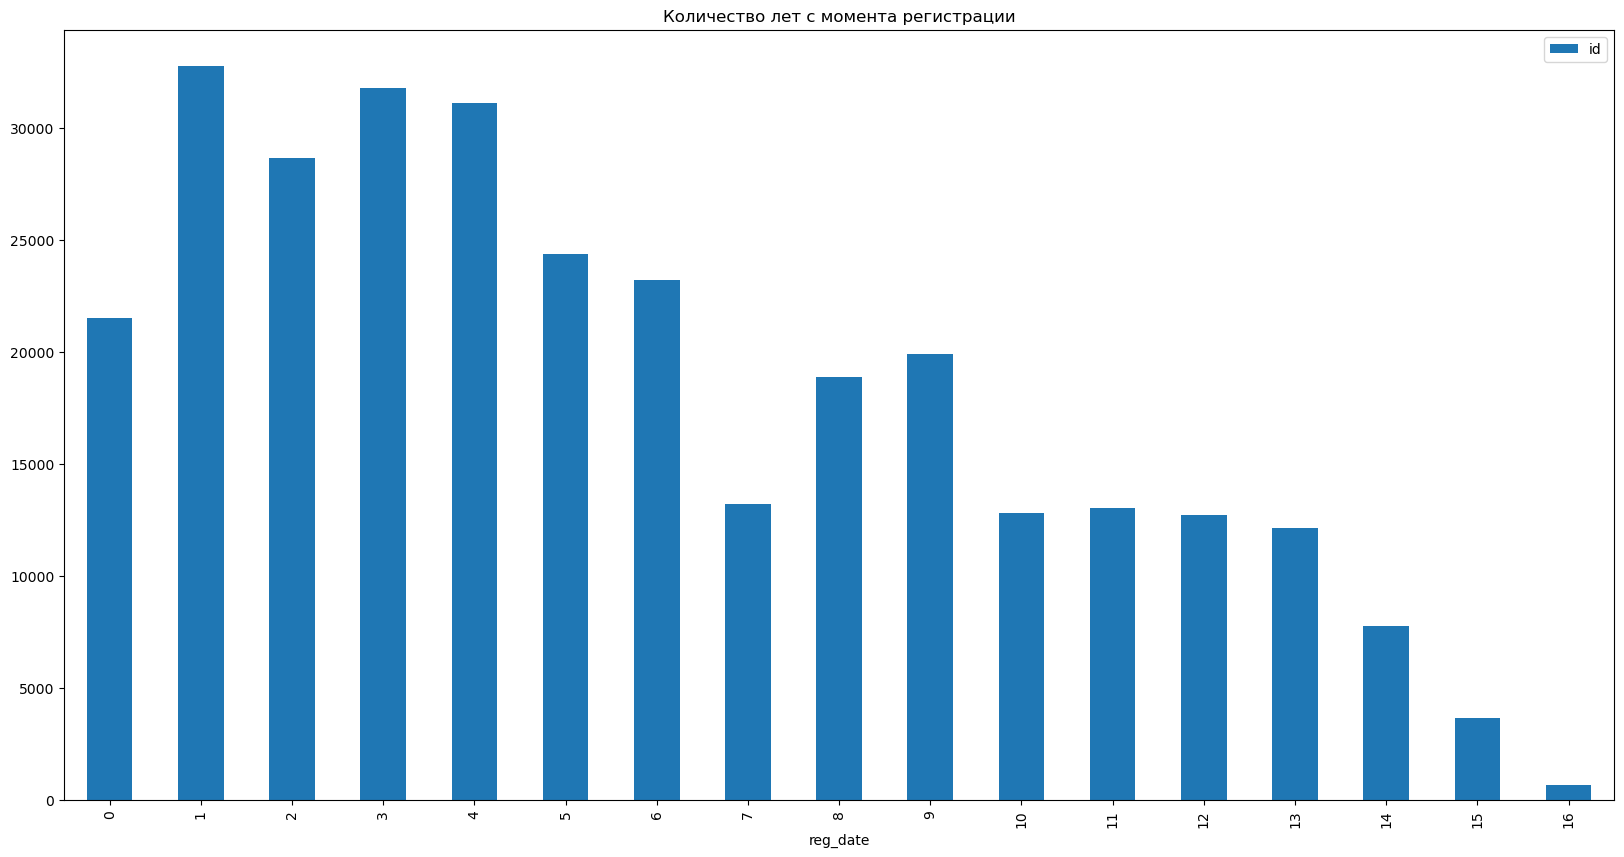

In [ ]:
# выведем распределение стажа лет на платформе
year = teachers_info.pivot_table(index='reg_date', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Количество лет с момента регистрации')
plt.show()

In [ ]:
# переименуем столбец
teachers_info.rename(columns={'reg_date' : 'reg_term'}, inplace=True)

Последние 7 лет прирост новых репетитов держится больше 20000 ежегодно. Столбец "0" показывает регистрацию до 1 года.

#### birth_date

Дату рождения переведем в возраст.

In [ ]:
# преобразуем признак
teachers_info['birth_date'] = pd.DatetimeIndex(teachers_info['birth_date'])
teachers_info['birth_date'] = [relativedelta(pd.to_datetime('now'), d).years for d in teachers_info['birth_date']]

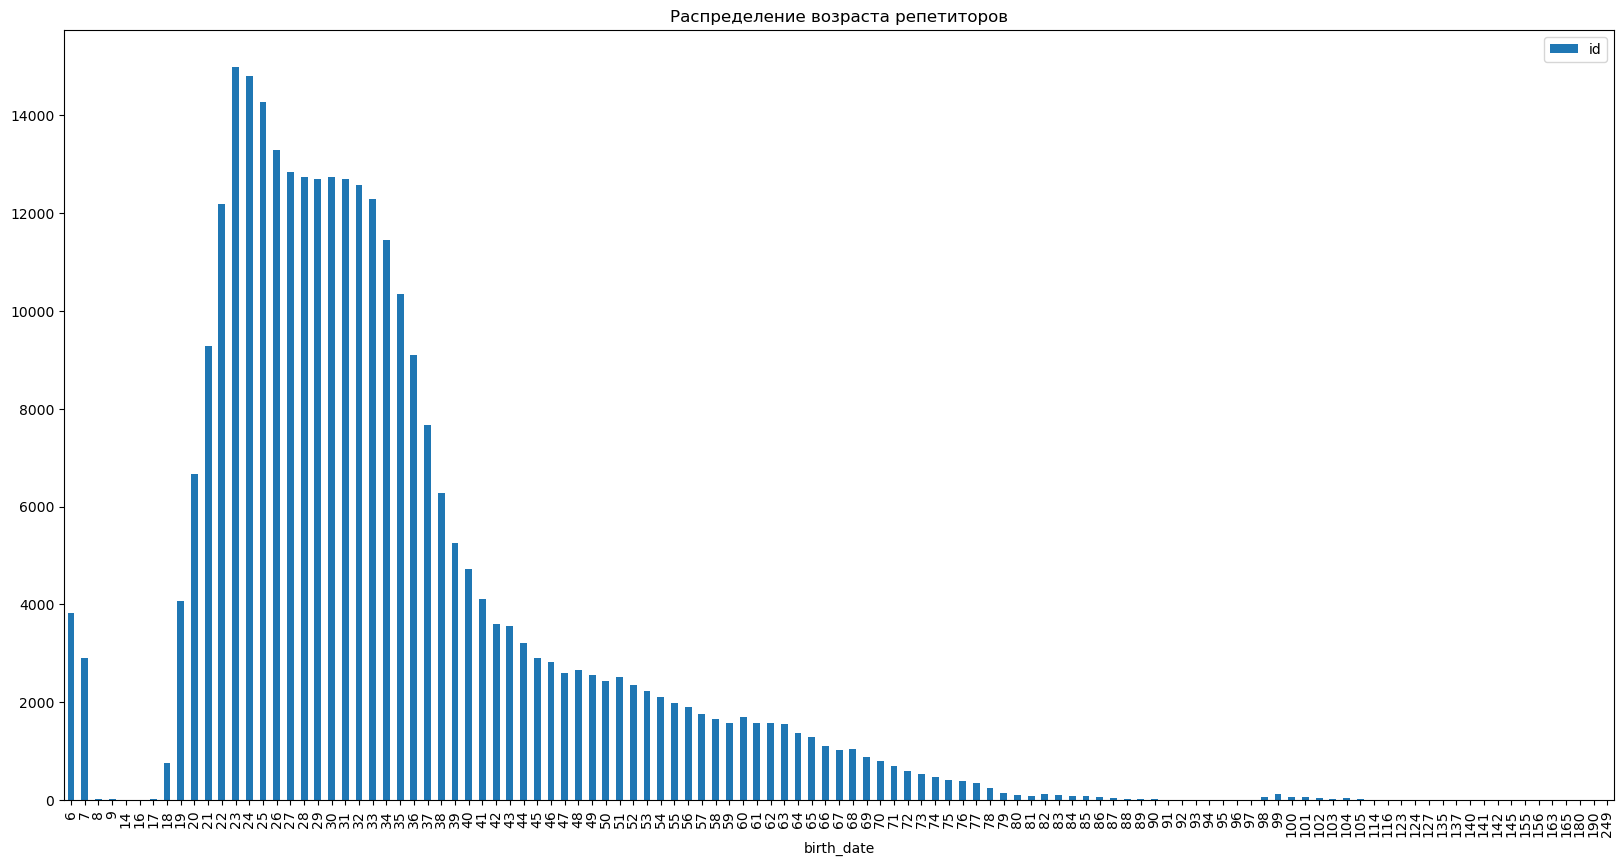

In [ ]:
# выведем распределение возраста репетиторов
year = teachers_info.pivot_table(index='birth_date', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Распределение возраста репетиторов')
plt.show()

Видим аномалии, оставим репетиторов от 18 до 85 (будем надеятся, что живчики такие есть).

In [ ]:
teachers_info = teachers_info.query('birth_date >= 18 & birth_date <= 85').reset_index(drop=True)

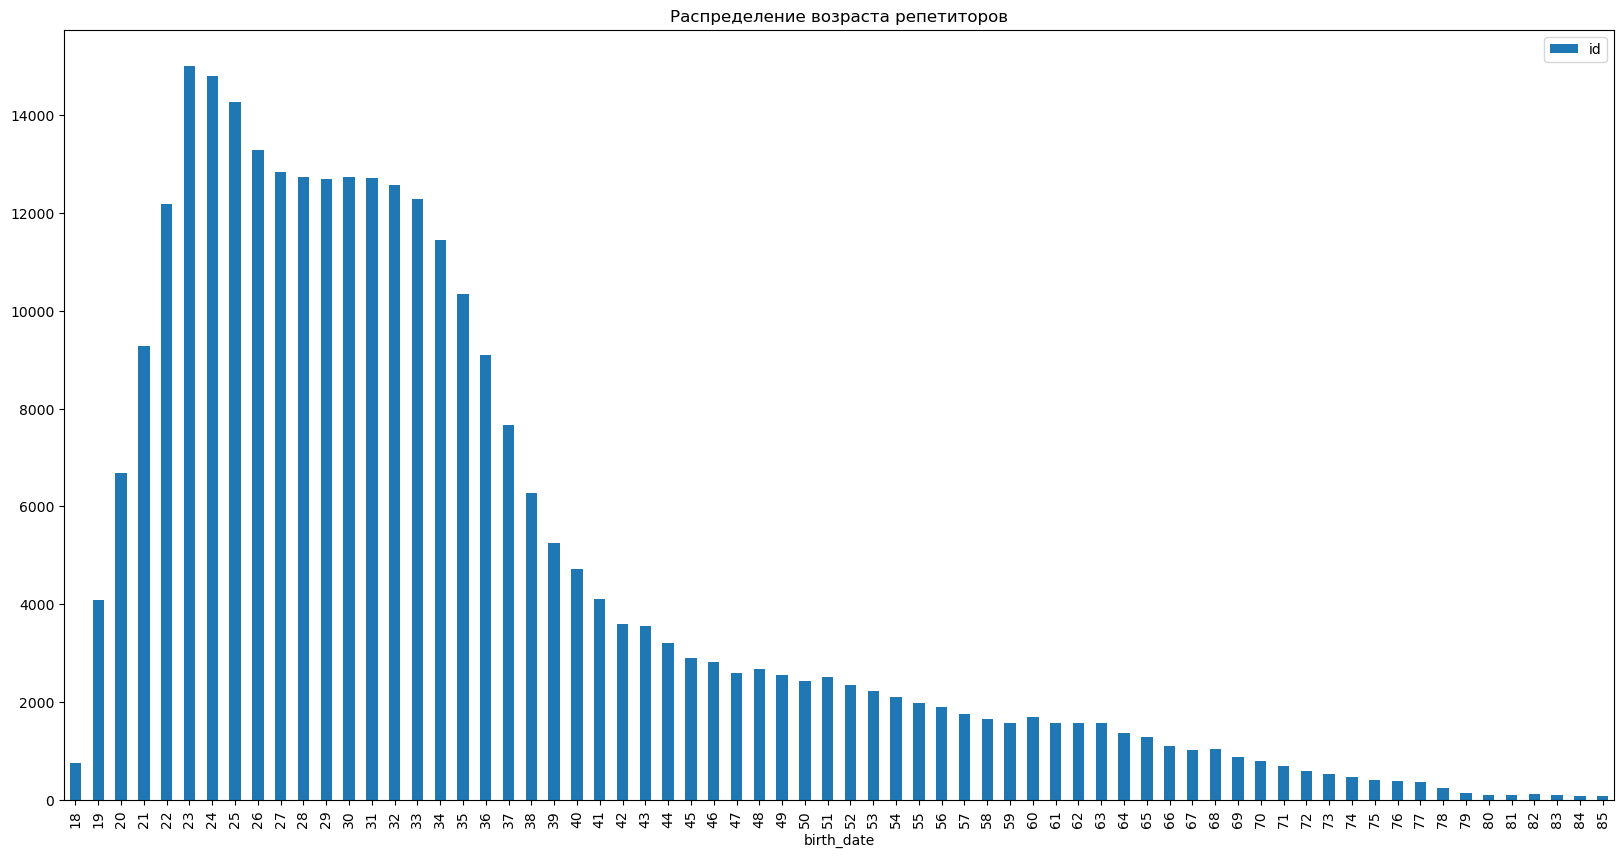

In [ ]:
# проверяем распределение возраста репетиторов
year = teachers_info.pivot_table(index='birth_date', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Распределение возраста репетиторов')
plt.show()

In [ ]:
# переименуем столбец солгласно изменениям
teachers_info.rename(columns={'birth_date': 'age'}, inplace=True)

#### teaching_start_date

Используя дату начала преподавания, определим стаж репетитора.

In [ ]:
# преобразуем признак
teachers_info['teaching_start_date'] = pd.DatetimeIndex(teachers_info['teaching_start_date'])
teachers_info['teaching_start_date'] = [relativedelta(pd.to_datetime('now'), d).years for d in teachers_info['teaching_start_date']]

In [ ]:
# переименуем столбец солгласно изменениям
teachers_info.rename(columns={'teaching_start_date': 'teach_term'}, inplace=True)

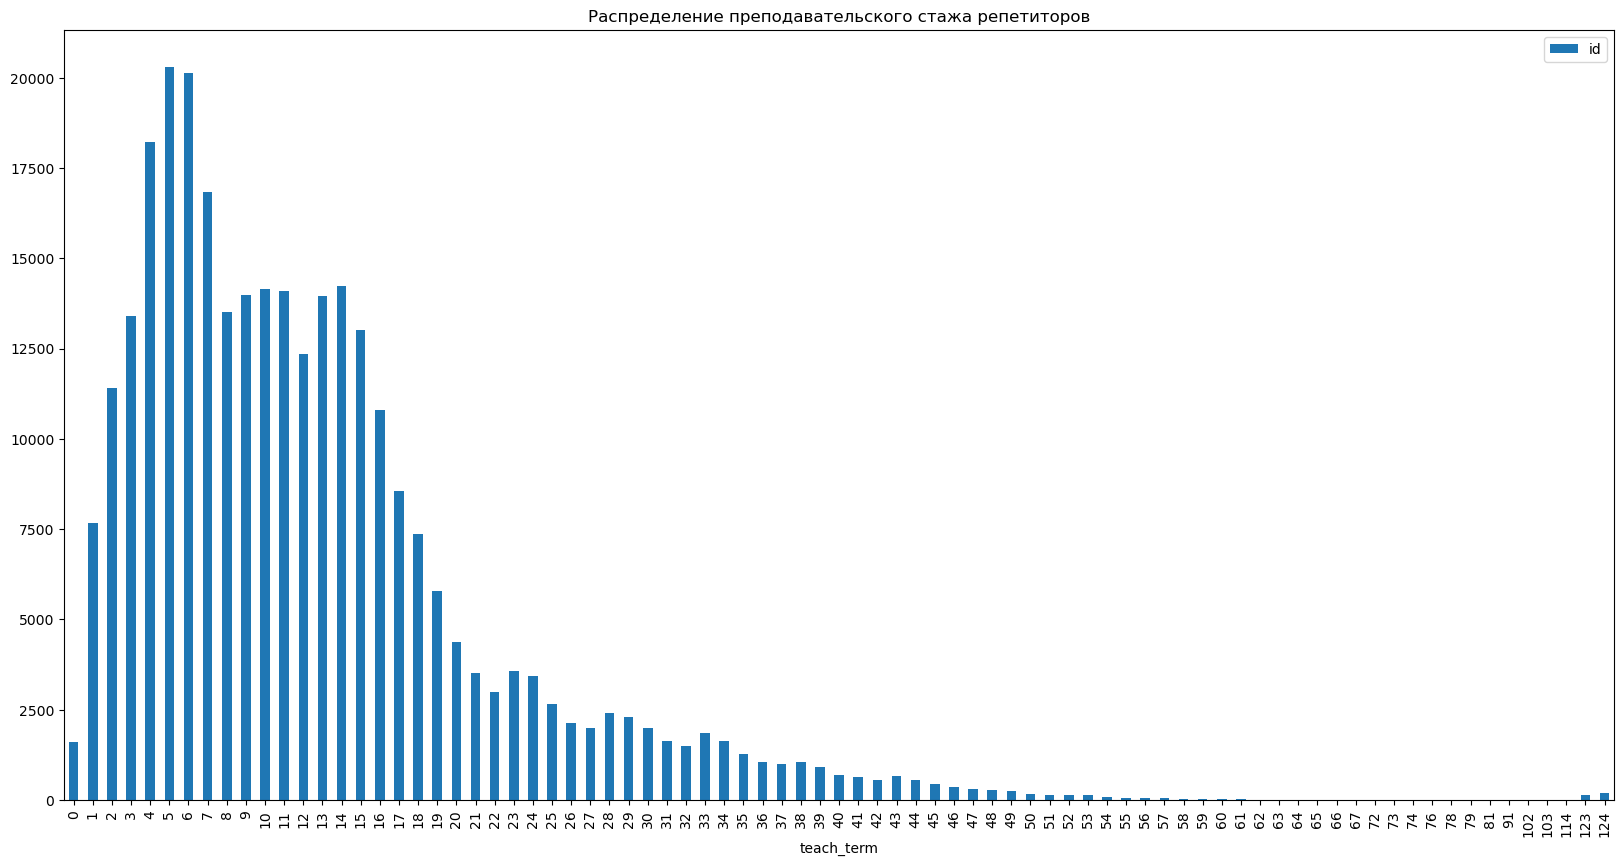

In [ ]:
# выведем распределение преподавательского стажа репетиторов
year = teachers_info.pivot_table(index='teach_term', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Распределение преподавательского стажа репетиторов')
plt.show()

Удалим выбросы. Максимальный стаж, согласно максимальному возрасту, предполагаю не более 67 лет.

In [ ]:
teachers_info = teachers_info.query('teach_term <= 67').reset_index(drop=True)

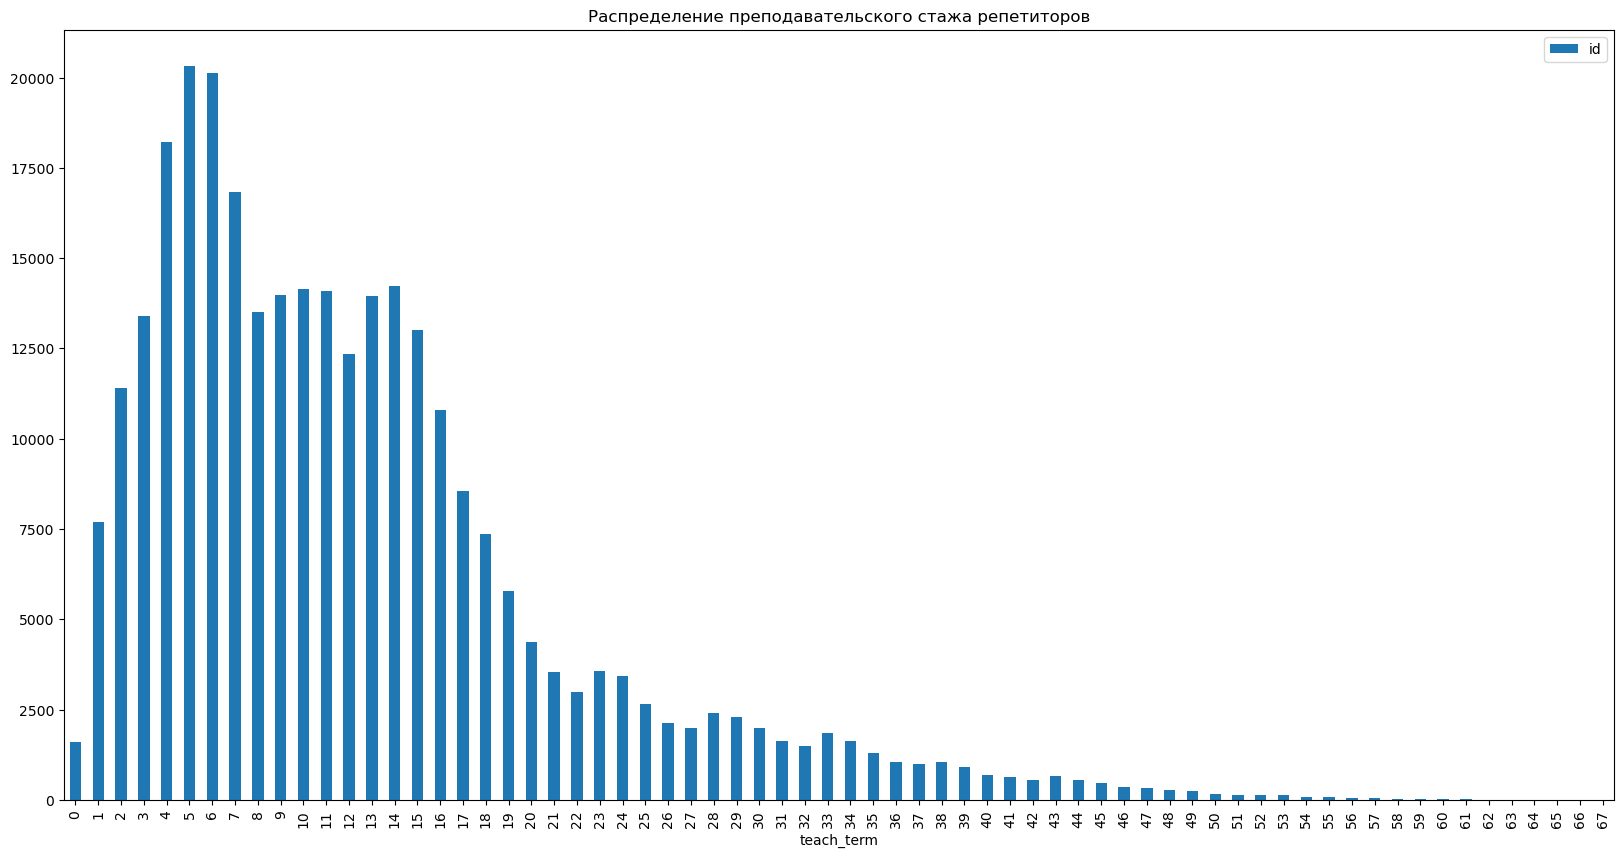

In [ ]:
# проверяем распределение преподавательского стажа репетиторов
year = teachers_info.pivot_table(index='teach_term', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Распределение преподавательского стажа репетиторов')
plt.show()

Удалим аномалии, где разница между возрастом и преподавательским стажем меньше 18 лет.

In [ ]:
teachers_info = teachers_info.loc[((teachers_info['age'] - teachers_info['teach_term']) >= 18)]

Отфильтруем аномалии, где преподавательский стаж репетитора меньше стажа пользования платформы.  

In [ ]:
teachers_info = teachers_info.loc[(teachers_info['teach_term'] >= teachers_info['reg_term'])]

#### is_email_confirmed

In [ ]:
# выводим значения репетиторов с подтвержденным  email
teachers_info['is_email_confirmed'].value_counts()

is_email_confirmed
0    266954
1      2922
Name: count, dtype: int64

Подтвержден только 1% от всего количества. После исследования корреляции с целевым признаком будем принимать решения о нужности данного признака.

In [ ]:
# переименуем столбец
teachers_info.rename(columns={'is_email_confirmed': 'email'}, inplace=True)

#### lesson_duration

In [ ]:
# выводим значения уроков по продолжительности
teachers_info['lesson_duration'].value_counts()

lesson_duration
60     214008
45      23876
90      21738
40       2669
30       2441
        ...  
77          1
609         1
990         1
132         1
33          1
Name: count, Length: 69, dtype: int64

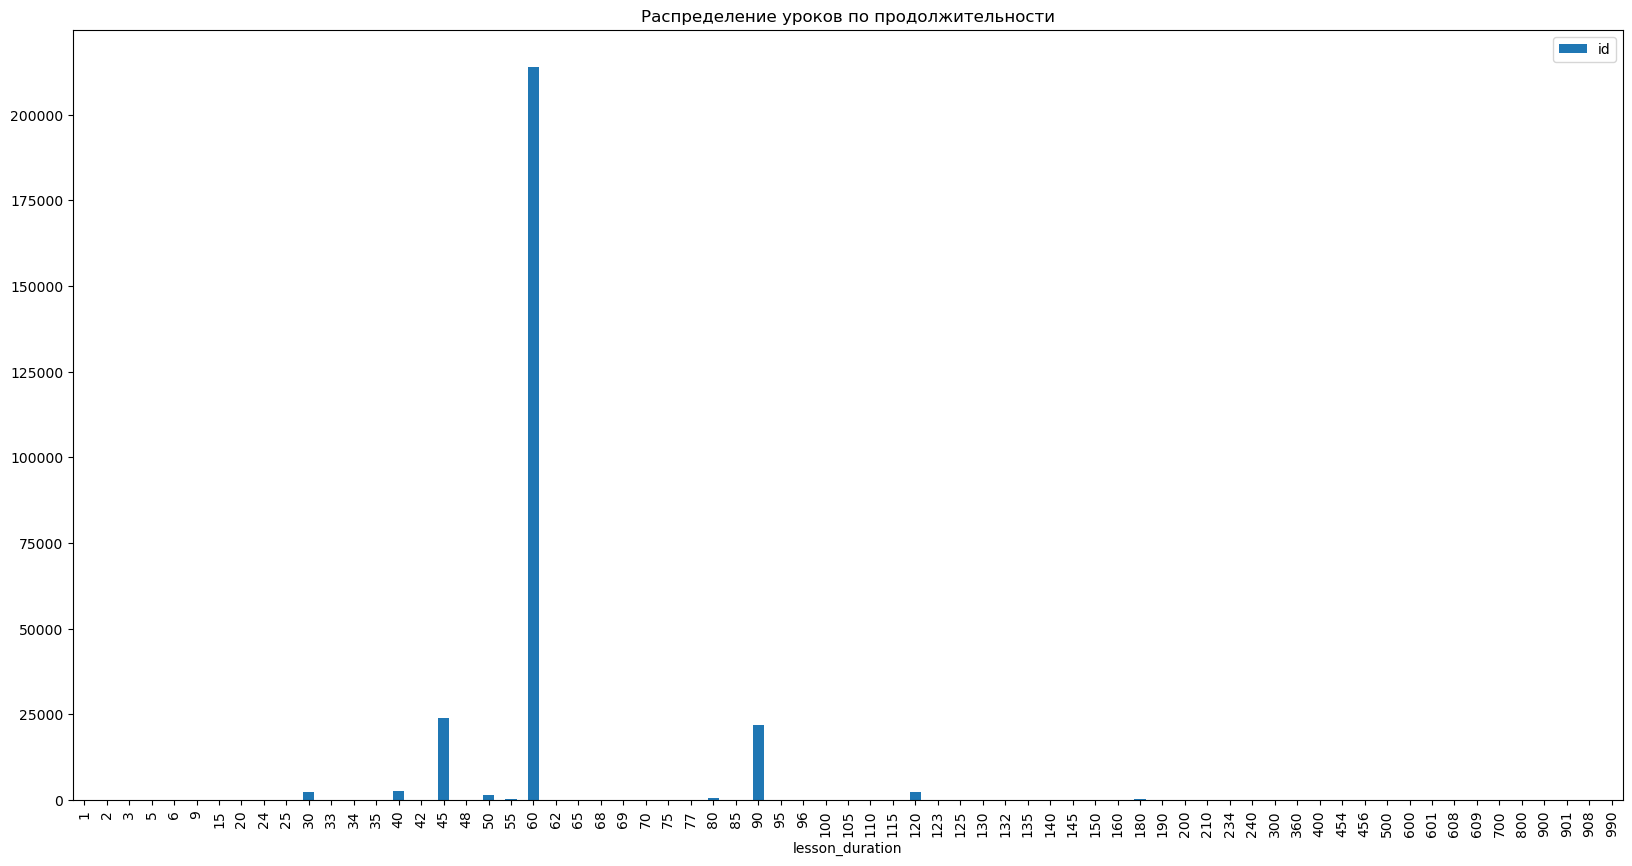

In [ ]:
# выведем распределение уроков по продолжительности
year = teachers_info.pivot_table(index='lesson_duration', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Распределение уроков по продолжительности')
plt.show()

Оставим самые популярные продолжительности.

In [ ]:
teachers_info = teachers_info.loc[teachers_info['lesson_duration'].isin([30, 40, 45, 50, 60, 90, 120])]

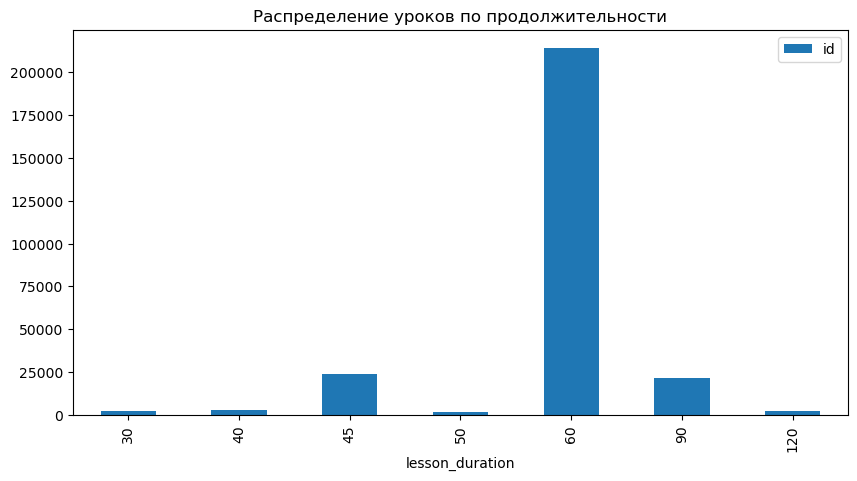

lesson_duration
60     214008
45      23876
90      21738
40       2669
30       2441
120      2195
50       1515
Name: count, dtype: int64

In [ ]:
# проверим распределение уроков по продолжительности
year = teachers_info.pivot_table(index='lesson_duration', values='id', aggfunc='count')
year.plot.bar(figsize = (10,5))
plt.title('Распределение уроков по продолжительности')
plt.show()
teachers_info['lesson_duration'].value_counts()

#### lesson_cost

In [ ]:
# выводим 50 самых популярных значений стоимости уроков
teachers_info['lesson_cost'].value_counts().nlargest(50)


lesson_cost
0       101779
1000     31091
500      25011
800      14761
1500     13259
600      13203
700      12133
400       8159
1200      7003
2000      5689
300       4423
900       4291
1         3463
350       2820
750       2488
10        2097
1300      2093
450       1922
2500      1662
3000      1159
250       1114
1800       985
1100       949
650        873
550        728
1400       706
1700       597
850        486
1600       461
1250       224
4000       216
3500       192
5000       186
200        159
950        146
2200       137
100        129
1350       123
2300       106
1900        69
2400        62
2250        59
737         53
589         51
2100        46
2700        45
442         40
1750        37
2800        35
370         35
Name: count, dtype: int64

По этому столбцу будем сравнивать с ценой на заявке, много значений "0", "1", "10". Также есть не "круглые" с пониженным значением меньше 500, может для привлечения внимания учеников. Будем рассматривать дальше, пока ничего не удаляю.

#### is_display

In [ ]:
# выводим значения нахождения в каталоге
teachers_info['is_display'].value_counts()

is_display
1    188336
0     80106
Name: count, dtype: int64

Большая часть находится в каталоге. Оставим данный признак до исследования корреляции.

#### last_visited

Преобразуем признак в формат даты, далее пригодится.

In [ ]:
# преобразуем признак
teachers_info['last_visited'] = pd.to_datetime(teachers_info['last_visited']).dt.normalize()


In [ ]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268442 entries, 1 to 300221
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       268442 non-null  int64         
 1   reg_term                 268442 non-null  int64         
 2   age                      268442 non-null  int64         
 3   teach_term               268442 non-null  int64         
 4   email                    268442 non-null  int64         
 5   lesson_duration          268442 non-null  int64         
 6   lesson_cost              268442 non-null  int64         
 7   is_display               268442 non-null  int64         
 8   last_visited             214794 non-null  datetime64[ns]
 9   is_pupils_needed         8803 non-null    float64       
 10  is_cell_phone_confirmed  268442 non-null  int64         
 11  area_id                  268442 non-null  int64         
 12  sex                  

Пропуски пока не заполняю, будем смотреть по обьединению таблиц и по мере необходимости.

#### is_pupils_needed

Проверим сколько пропусков.

In [ ]:
display(teachers_info['is_pupils_needed'].isna().sum())

259639

In [ ]:
# выводим значения необходимости в учениках
teachers_info['is_pupils_needed'].value_counts()

is_pupils_needed
1.0    8323
0.0     480
Name: count, dtype: int64

Предварительно, заполним пропуски индикотором - 3 (нет информации), в финальном датафрейме будет видно в необходимости данного признака.

In [ ]:
teachers_info['is_pupils_needed'] = teachers_info['is_pupils_needed'].fillna('3')

Наведём красоту.

In [ ]:
teachers_info['is_pupils_needed'] = teachers_info['is_pupils_needed'].astype(int)

#### is_cell_phone_confirmed

In [ ]:
# выводим значения репетиторов с подтвержденным номером телефона
teachers_info['is_cell_phone_confirmed'].value_counts()

is_cell_phone_confirmed
0    266727
1      1715
Name: count, dtype: int64

Также, как и с почтой около 1% подтвержденых номеров телефона. После исследования корреляции с целевым признаком будем принимать решения о нужности данного признака.

In [ ]:
# переименуем столбец
teachers_info.rename(columns={'is_cell_phone_confirmed': 'phone'}, inplace=True)

#### area_id

In [ ]:
# выводим регионы местопроживания репетиторов
teachers_info['area_id'].value_counts()

area_id
1     147806
2      38418
14      4829
4       4217
6       4033
       ...  
86        29
78        22
76        15
89         7
83         3
Name: count, Length: 90, dtype: int64

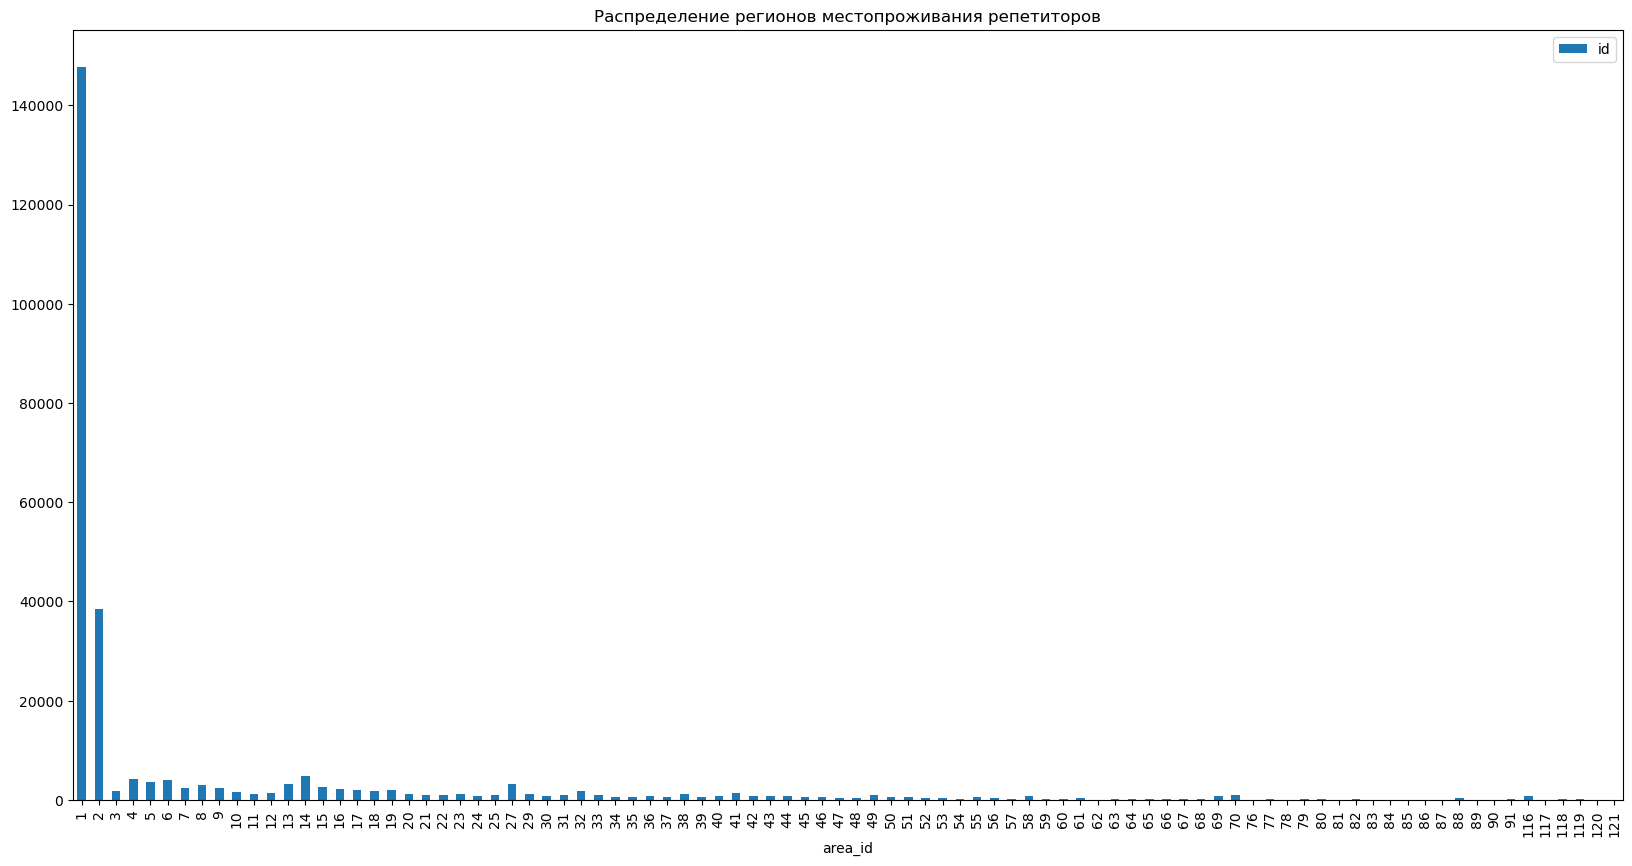

In [ ]:
# выведем распределение регионов местопроживания репетиторов
year = teachers_info.pivot_table(index='area_id', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Распределение регионов местопроживания репетиторов')
plt.show()

В России на данный момент 89 субьектов. Первые два, есть предположения, что это Москва и Питер. Согласно конституции оставим 89 регионов.

In [ ]:
teachers_info = teachers_info.query('area_id <= 89').reset_index(drop=True)

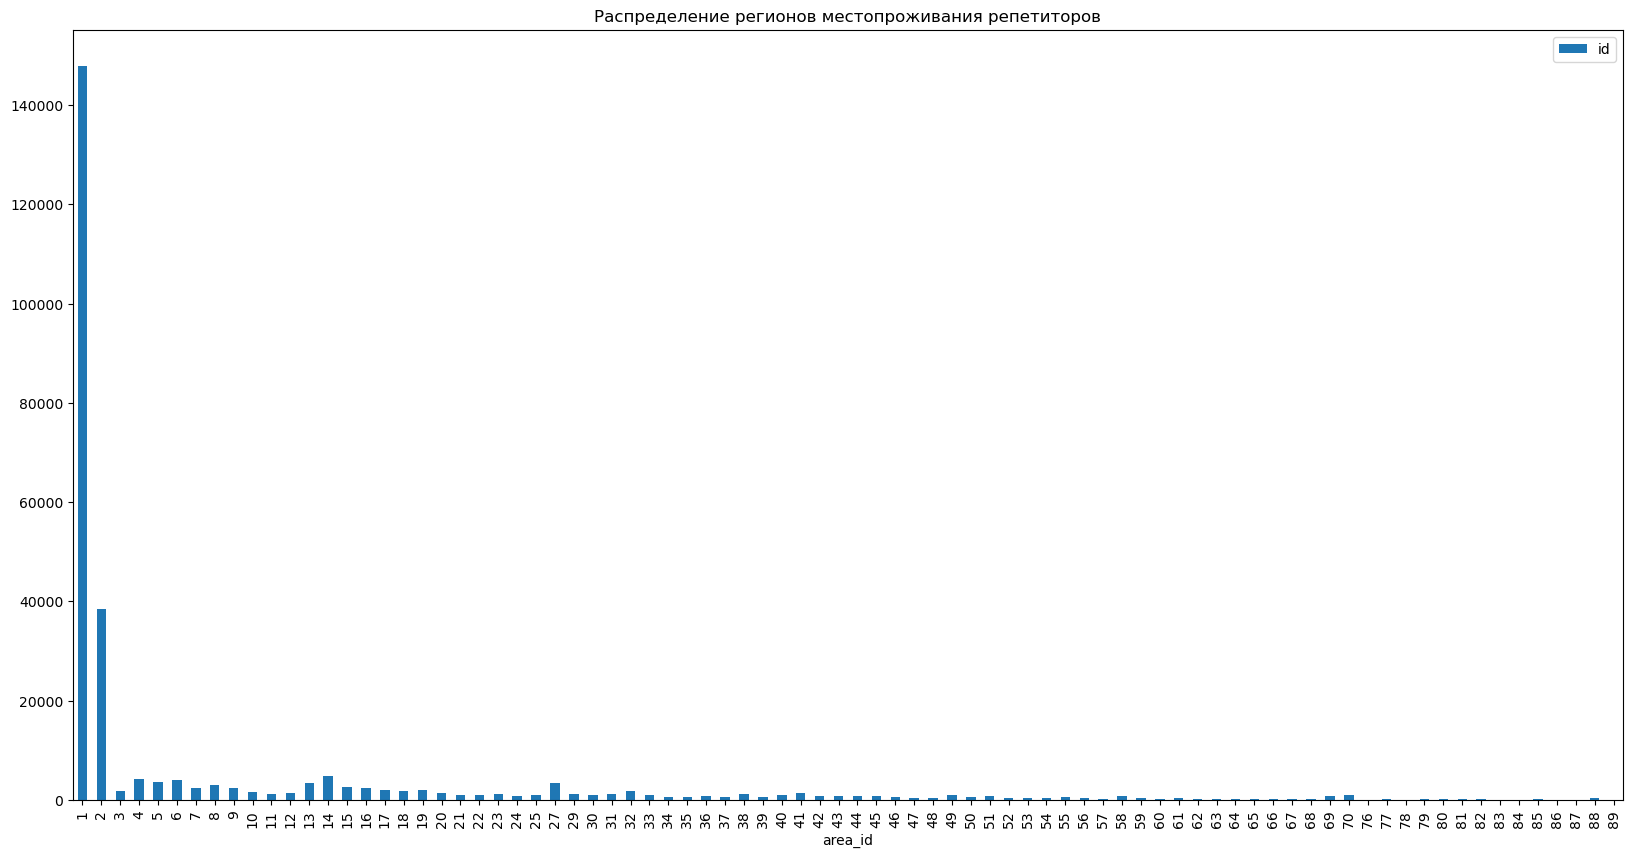

In [ ]:
# проверяем распределение регионов местопроживания репетиторов
year = teachers_info.pivot_table(index='area_id', values='id', aggfunc='count')
year.plot.bar(figsize = (20,10))
plt.title('Распределение регионов местопроживания репетиторов')
plt.show()

Также оставим признак для исследования корреляции.

#### sex

In [ ]:
# выводим гендер репетиторов
teachers_info['sex'].value_counts()

sex
2    199834
1     65770
3      1402
0         2
Name: count, dtype: int64

3 - нет информации. 0 удалим.

In [ ]:
teachers_info = teachers_info.query('sex != 0').reset_index(drop=True)

In [ ]:
# проверим гендер репетиторов
teachers_info['sex'].value_counts()

sex
2    199834
1     65770
3      1402
Name: count, dtype: int64

Оставляем признак для исследования корреляции с целевым признаком.

#### orders_allowed

In [ ]:
# выводим значения разрешений репетиторов на заявки
teachers_info['orders_allowed'].value_counts()

orders_allowed
1    229269
0     37737
Name: count, dtype: int64

Оставляем признак для исследования корреляции с целевым признаком.

#### review_num

In [ ]:
# выводим значения отзывов на репетиторов
teachers_info['review_num'].value_counts().nlargest(50)

review_num
0     214840
1      16882
2       8094
3       5067
4       3707
5       2731
6       2183
7       1724
8       1327
9       1167
10       947
11       840
12       699
13       639
14       546
15       487
16       466
17       352
18       329
19       312
20       270
21       250
22       239
23       230
24       191
25       176
26       157
28       146
29       133
27       123
31       108
30       106
33        98
32        90
34        87
35        82
36        76
38        63
39        62
37        61
41        50
43        48
40        40
42        40
45        39
47        38
44        36
46        33
53        30
51        29
Name: count, dtype: int64

Отзывы какаи-то образом отмаркированы, непонятно как, но оставим наиболее популярные.

In [ ]:
teachers_info = teachers_info.query('review_num <= 55').reset_index(drop=True)

In [ ]:
# проверяем значения отзывов на репетиторов
teachers_info['review_num'].value_counts()

review_num
0     214840
1      16882
2       8094
3       5067
4       3707
5       2731
6       2183
7       1724
8       1327
9       1167
10       947
11       840
12       699
13       639
14       546
15       487
16       466
17       352
18       329
19       312
20       270
21       250
22       239
23       230
24       191
25       176
26       157
28       146
29       133
27       123
31       108
30       106
33        98
32        90
34        87
35        82
36        76
38        63
39        62
37        61
41        50
43        48
40        40
42        40
45        39
47        38
44        36
46        33
53        30
51        29
49        28
50        28
52        21
48        21
55        21
54        20
Name: count, dtype: int64

### Финальная таблица "teachers_info"

In [ ]:
display(teachers_info)

,id,reg_term,age,teach_term,email,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,phone,area_id,sex,orders_allowed,review_num
0,46,16,44,20,0,60,500,0,NaT,1,0,1,3,1,0
1,51,16,58,35,0,60,1500,0,2022-09-26,1,0,1,2,1,0
2,52,16,35,17,0,60,1000,1,2020-04-03,0,0,1,2,1,2
3,54,16,38,20,0,45,400,0,NaT,1,0,1,3,1,0
4,73,16,67,36,0,60,1000,0,2014-04-16,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266604,312618,0,46,24,0,60,0,1,NaT,3,0,18,2,0,0
266605,312619,0,43,6,0,60,0,1,NaT,3,0,1,2,0,0
266606,312620,0,19,1,0,60,0,1,NaT,3,0,1,2,1,0
266607,312621,0,24,2,0,60,0,1,NaT,3,0,1,2,1,0


### Таблица "teachers"

In [ ]:
# ознакомимся с датафреймом статистики репетиторов
for df in [teachers]:
    display(df.info())
    print('')
    print('Количество пропусков:')
    display(df.isna().sum())
    display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


None


Количество пропусков:


id                          0
lessons_delivered           0
mean_lesson_price           0
lessons_given               0
lessons_started_fraction    0
lessons_per_pupil           0
money_recieved              0
blocked                     0
dtype: int64

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0
...,...,...,...,...,...,...,...,...
1651,294498,1.0,1500.000000,1.0,0.166667,1.000000,1500.0,0
1652,3619,1.0,1300.000000,1.0,0.111111,1.000000,1300.0,0
1653,238509,4.0,900.000000,1.0,0.071429,1.000000,900.0,1
1654,180353,1.0,1700.000000,1.0,0.100000,1.000000,1700.0,0


#### id

In [ ]:
# проверяем дубликаты id репетиторов
teachers['id'].is_unique

True

Дубликатов нет

#### lessons_delivered

In [ ]:
# преобразуем тип признака
teachers['lessons_delivered'] = teachers['lessons_delivered'].astype(int)

In [ ]:
# выводим значения количества поставленных уроков репетиторам
teachers['lessons_delivered'].value_counts()

lessons_delivered
1       63
4       50
3       49
2       48
5       40
        ..
528      1
1600     1
825      1
5690     1
170      1
Name: count, Length: 493, dtype: int64

count    1656.000000
mean      177.651570
std       336.451272
min         1.000000
25%        12.000000
50%        54.000000
75%       207.500000
max      5690.000000
Name: lessons_delivered, dtype: float64

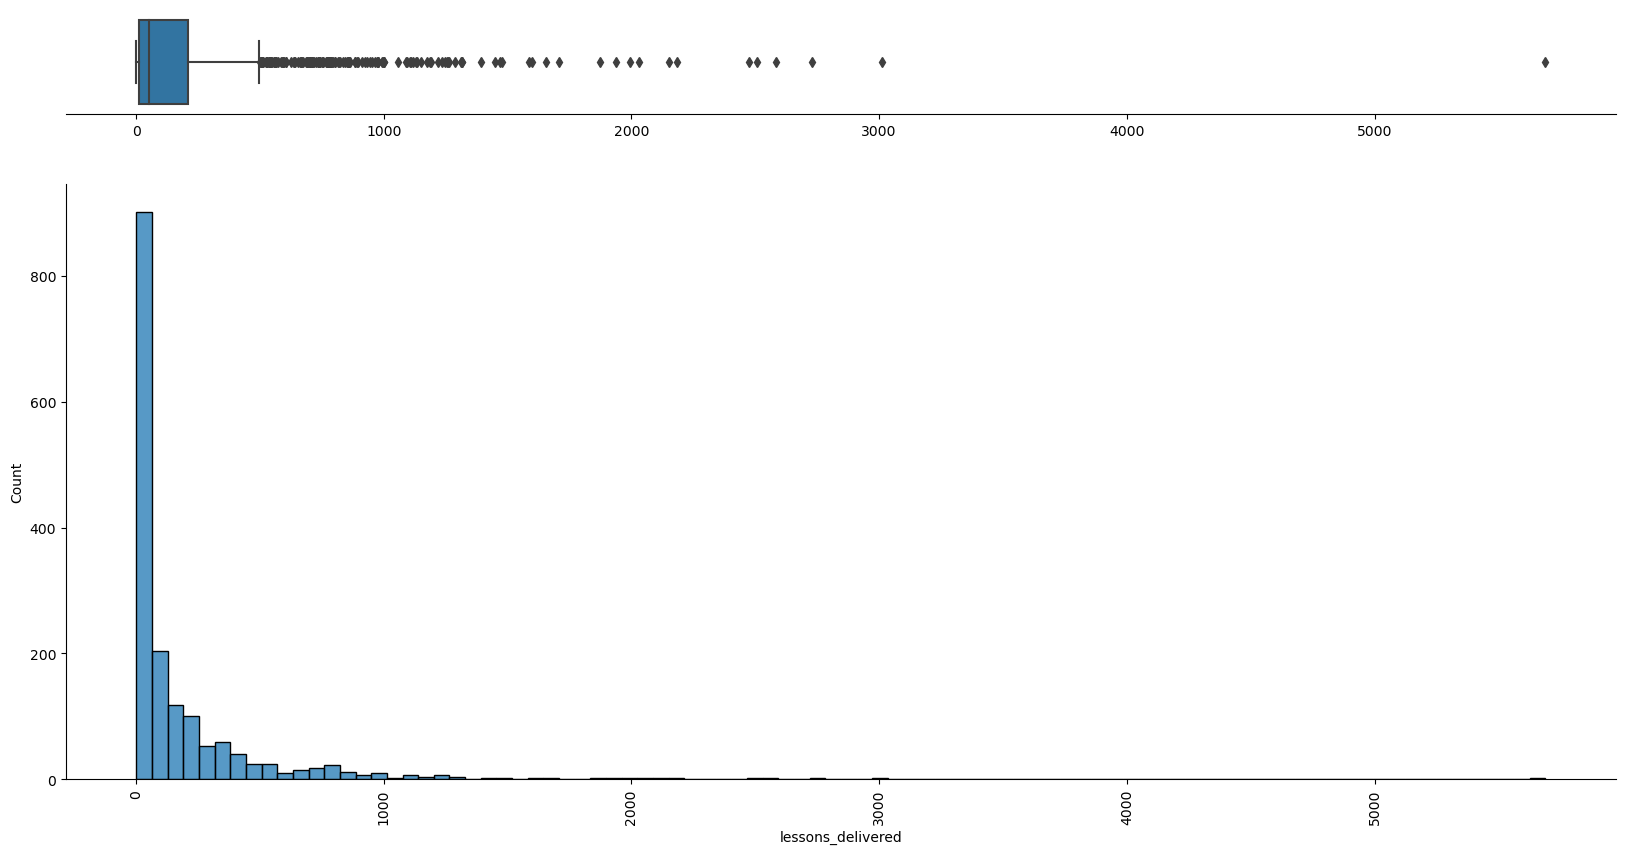

In [ ]:
# выводим распределение количества поставленных уроков репетиторам
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,10))
sns.boxplot(x=teachers['lessons_delivered'], ax=ax_1)
sns.histplot(x=teachers['lessons_delivered'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis= 'x', labelrotation=90)

teachers['lessons_delivered'].describe()

Есть значения, много больше среднего, посмотрим репетиторов с количеством поставленных уроков больше 1500.

In [ ]:
teachers.query('lessons_delivered > 1500')

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
9,128014,2185,3531.250000,1520.0,0.666667,54.285714,5367500.0,0
17,145938,2030,1997.892074,1186.0,0.352113,47.440000,2369500.0,0
21,124543,1585,3221.422142,1111.0,0.378788,44.440000,3579000.0,0
26,232748,2505,1877.213740,1310.0,0.449275,42.258065,2459150.0,0
27,151958,1936,1303.640146,1923.0,0.707692,41.804348,2506900.0,0
63,224381,1655,1539.434629,1415.0,0.328671,30.106383,2178300.0,0
74,9245,3012,2243.610447,2508.0,0.500000,28.179775,5626975.0,0
186,108634,2729,2234.973532,2078.0,0.507614,20.780000,4644275.0,0
214,143227,2150,630.967742,775.0,0.588235,19.375000,489000.0,0
219,301671,2582,404.270833,480.0,0.290698,19.200000,194050.0,0


#### mean_lesson_price

count     1656.000000
mean      1509.636125
std        908.722960
min        200.000000
25%        994.880952
50%       1350.308642
75%       1852.012502
max      15000.000000
Name: mean_lesson_price, dtype: float64

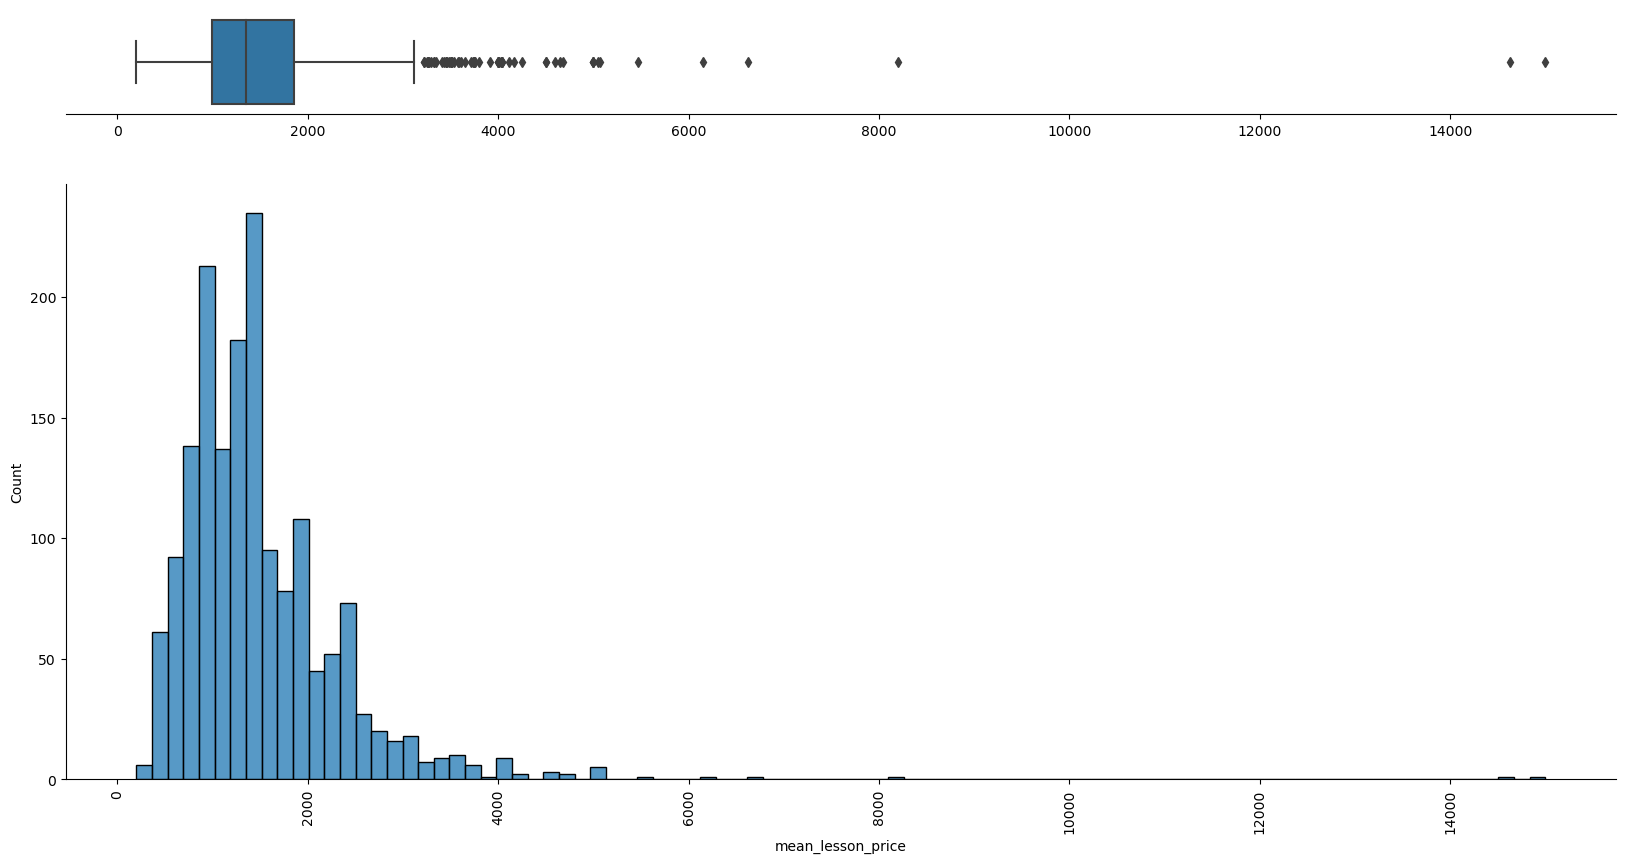

In [ ]:
# выводим значения средней цены уроков репетиторов
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,10))
sns.boxplot(x=teachers['mean_lesson_price'], ax=ax_1)
sns.histplot(x=teachers['mean_lesson_price'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis= 'x', labelrotation=90)

teachers['mean_lesson_price'].describe()

Рассмотрим репетитров со средней ценой больше 4500

In [ ]:
teachers.query('mean_lesson_price > 4500')

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
95,13422,143,4504.716981,53.0,0.076923,26.500000,238750.0,0
171,102227,739,4678.445230,283.0,0.134021,21.769231,1324000.0,0
479,124473,43,4600.000000,36.0,0.428571,12.000000,165600.0,0
644,84913,48,4648.936170,47.0,0.384615,9.400000,218500.0,0
653,125489,215,6627.272727,55.0,0.461538,9.166667,364500.0,0
742,114012,55,14625.000000,8.0,0.030303,8.000000,117000.0,1
913,45382,32,5050.000000,30.0,0.192308,6.000000,151500.0,0
914,282114,6,5066.666667,6.0,0.111111,6.000000,30400.0,0
1032,71014,110,6150.000000,10.0,0.200000,5.000000,61500.0,0
1083,78354,9,5000.000000,9.0,0.095238,4.500000,45000.0,1


Единичные случаи, при обучении будем экспериментировать, может прийдется отфильровать.

In [ ]:
# округлим до сотых
teachers['mean_lesson_price'] = teachers['mean_lesson_price'].round(2)

#### lessons_given

In [ ]:
# преобразуем тип признака
teachers['lessons_given'] = teachers['lessons_given'].astype(int)

count    1656.000000
mean      104.064614
std       217.635955
min         1.000000
25%         8.000000
50%        30.000000
75%       103.000000
max      3788.000000
Name: lessons_given, dtype: float64

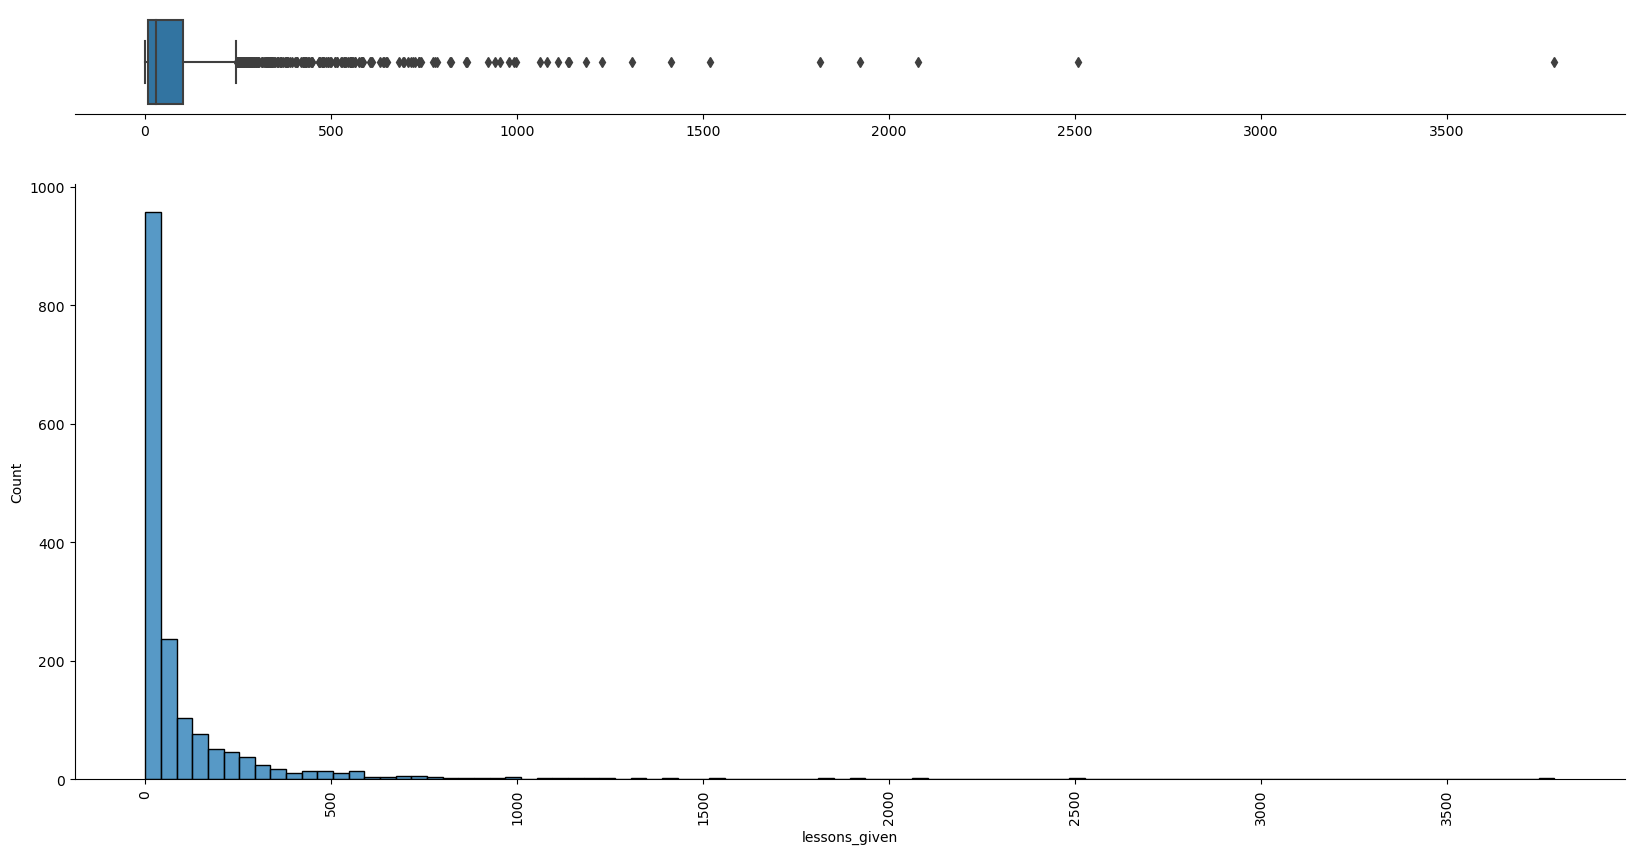

In [ ]:
# выводим распределение количества поставленных уроков репетиторам
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,10))
sns.boxplot(x=teachers['lessons_given'], ax=ax_1)
sns.histplot(x=teachers['lessons_given'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis= 'x', labelrotation=90)

teachers['lessons_given'].describe()

In [ ]:
teachers.query('lessons_given > 1000')

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
1,153845,1111,884.09,1082,0.358974,77.285714,956580.0,0
9,128014,2185,3531.25,1520,0.666667,54.285714,5367500.0,0
17,145938,2030,1997.89,1186,0.352113,47.440000,2369500.0,0
21,124543,1585,3221.42,1111,0.378788,44.440000,3579000.0,0
26,232748,2505,1877.21,1310,0.449275,42.258065,2459150.0,0
27,151958,1936,1303.64,1923,0.707692,41.804348,2506900.0,0
40,2791,1149,1849.56,1138,0.469697,36.709677,2104800.0,0
63,224381,1655,1539.43,1415,0.328671,30.106383,2178300.0,0
74,9245,3012,2243.61,2508,0.500000,28.179775,5626975.0,0
186,108634,2729,2234.97,2078,0.507614,20.780000,4644275.0,0


Не много таких работяг. Оставим.

#### lessons_started_fraction

In [ ]:
# округлим до сотых
teachers['lessons_started_fraction'] = teachers['lessons_started_fraction'].round(2)

count    1656.000000
mean        0.194819
std         0.135164
min         0.010000
25%         0.110000
50%         0.170000
75%         0.250000
max         1.000000
Name: lessons_started_fraction, dtype: float64

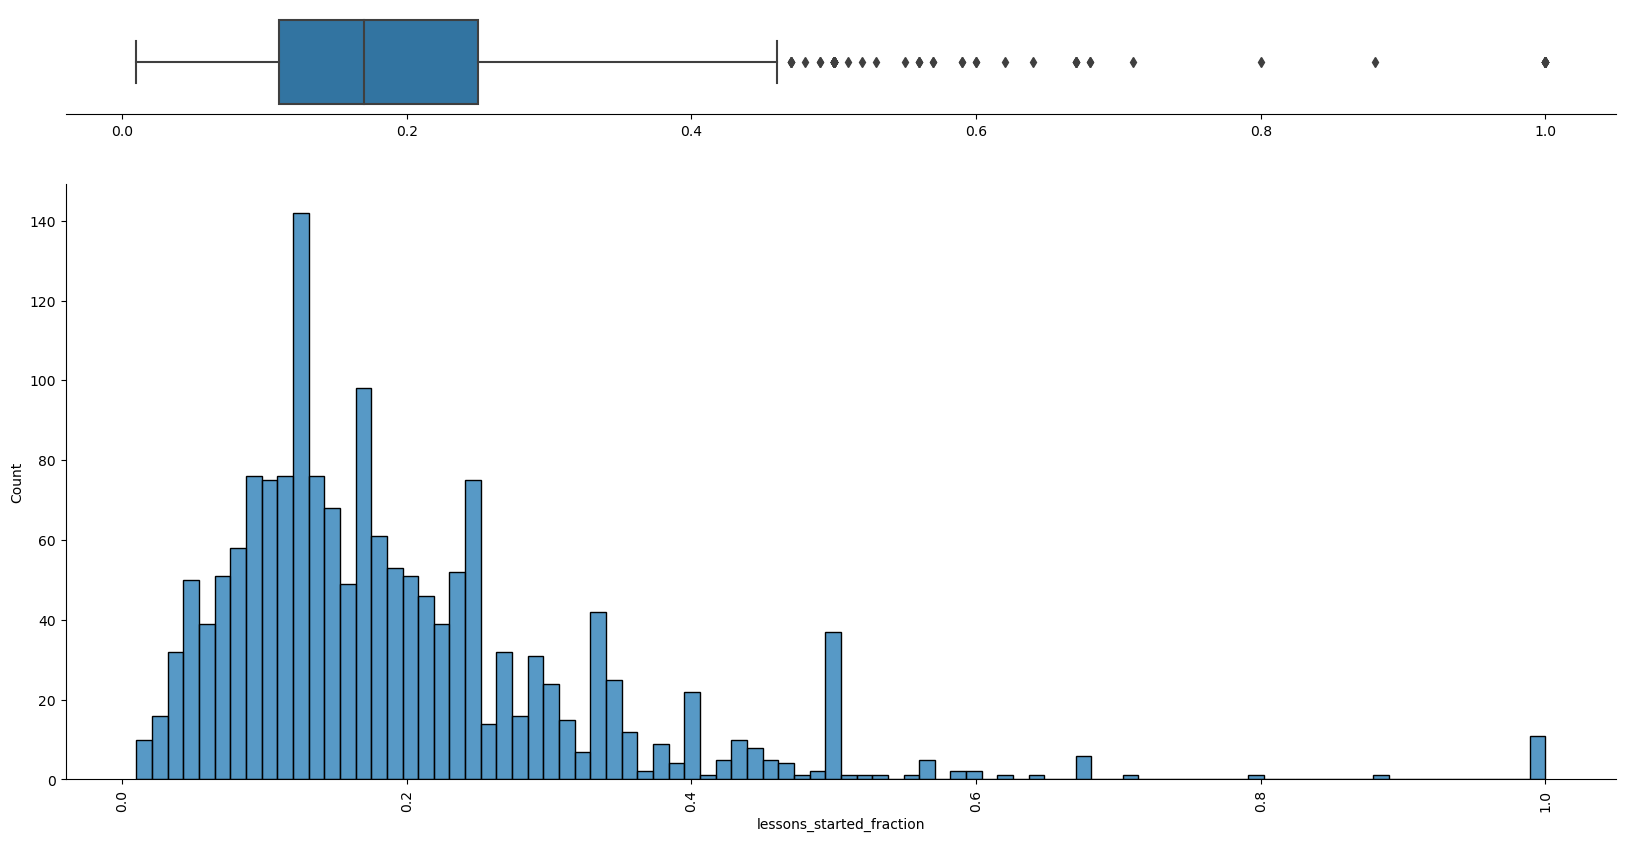

In [ ]:
# выводим распределение процентов начала занятий репетиторов
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,10))
sns.boxplot(x=teachers['lessons_started_fraction'], ax=ax_1)
sns.histplot(x=teachers['lessons_started_fraction'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis= 'x', labelrotation=90)

teachers['lessons_started_fraction'].describe()

Исследование корреляции покажет влияние на целевой признак.

#### lessons_per_pupil

In [ ]:
# преобразуем тип признака
teachers['lessons_per_pupil'] = teachers['lessons_per_pupil'].astype(int)

count    1656.000000
mean        9.561594
std         9.553403
min         1.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        78.000000
Name: lessons_per_pupil, dtype: float64

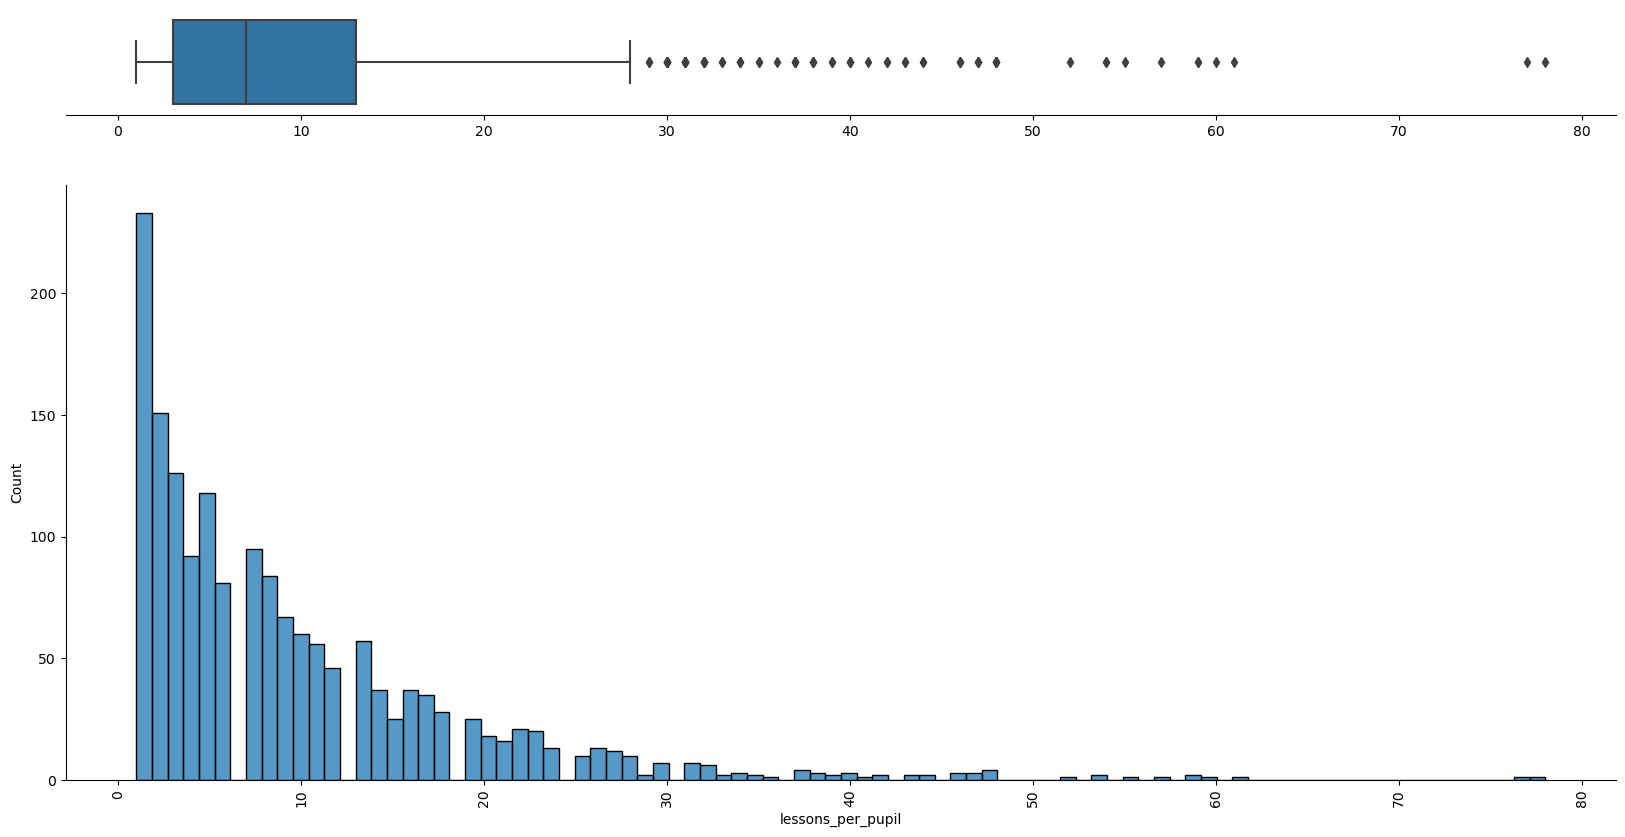

In [ ]:
# выводим распределение количества занятий на ученика
f,(ax_1, ax_2) = plt.subplots(2, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(20,10))
sns.boxplot(x=teachers['lessons_per_pupil'], ax=ax_1)
sns.histplot(x=teachers['lessons_per_pupil'], ax=ax_2, bins=90)
ax_1.set(yticks=[], xlabel=None)
sns.despine(ax=ax_1, left=True); sns.despine(ax=ax_2)
ax_2.tick_params(axis= 'x', labelrotation=90)

teachers['lessons_per_pupil'].describe()

In [ ]:
teachers.query('lessons_per_pupil > 60')

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470,1284.22,469,0.67,78,602300.0,0
1,153845,1111,884.09,1082,0.36,77,956580.0,0
2,42869,505,2500.00,184,0.14,61,460000.0,0


#### money_recieved

In [ ]:
# преобразуем тип признака
teachers['money_recieved'] = teachers['money_recieved'].astype(int)

In [ ]:
teachers['money_recieved'].describe()

count    1.656000e+03
mean     1.750237e+05
std      4.850086e+05
min      2.000000e+02
25%      9.000000e+03
50%      4.310000e+04
75%      1.483500e+05
max      1.116220e+07
Name: money_recieved, dtype: float64

Признак является произведением, оплаченных уроков на среднюю цену, что логично.

#### blocked

In [ ]:
# выводим значения количества заблокированных и активных репетиторов
teachers['blocked'].value_counts()

blocked
0    1099
1     557
Name: count, dtype: int64

Отметим дисбаланс, что нужно будет учесть при обучении модели.

### Финальная таблица "teachers"

In [ ]:
display(teachers)

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470,1284.22,469,0.67,78,602300,0
1,153845,1111,884.09,1082,0.36,77,956580,0
2,42869,505,2500.00,184,0.14,61,460000,0
3,127280,442,1879.34,363,0.15,60,682200,0
4,283905,694,1252.43,534,0.26,59,668800,0
...,...,...,...,...,...,...,...,...
1651,294498,1,1500.00,1,0.17,1,1500,0
1652,3619,1,1300.00,1,0.11,1,1300,0
1653,238509,4,900.00,1,0.07,1,900,1
1654,180353,1,1700.00,1,0.10,1,1700,0


### Таблица "pupils"

Оставим столбцы, как по - моей оценке нужны для обучения модели

In [ ]:
pupils = pupils[['id', 'client_id', 'teacher_id', 'order_id', 'lesson_price', 'is_active', 'suspend_till_date']]

Оставим учеников со статусом "активный"

In [ ]:
pupils = pupils.query('is_active == 1')

Отфильтруем от пропусков в столбце заявок

In [ ]:
pupils = pupils.dropna(subset=['order_id'])

Подкорректируем формат столбцов

In [ ]:
pupils['client_id'] = pupils['client_id'].astype(int)
pupils['order_id'] = pupils['order_id'].astype(int)
pupils['suspend_till_date'] = pd.to_datetime(pupils['suspend_till_date'], infer_datetime_format=True)

In [ ]:
# ознакомимся с данными учеников
for df in [pupils]:
    display(df.info())
    print('')
    print('Количество пропусков:')
    display(df.isna().sum())
    display(df)

<class 'pandas.core.frame.DataFrame'>
Index: 197050 entries, 0 to 893437
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 197050 non-null  int64         
 1   client_id          197050 non-null  int64         
 2   teacher_id         197050 non-null  int64         
 3   order_id           197050 non-null  int64         
 4   lesson_price       197050 non-null  int64         
 5   is_active          197050 non-null  int64         
 6   suspend_till_date  197050 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(6)
memory usage: 12.0 MB


None


Количество пропусков:


id                   0
client_id            0
teacher_id           0
order_id             0
lesson_price         0
is_active            0
suspend_till_date    0
dtype: int64

,id,client_id,teacher_id,order_id,lesson_price,is_active,suspend_till_date
0,240884,427831,133738,718009,1000,1,2018-08-27
10,244777,430584,117781,724347,1000,1,1800-01-01
13,246352,431616,22471,728342,0,1,2020-09-20
15,247733,427368,22471,730437,0,1,2020-08-20
18,248721,433880,93099,732192,700,1,1800-01-01
...,...,...,...,...,...,...,...
893428,1471867,1250910,281998,2887936,1500,1,1800-01-01
893429,1471868,1151582,65041,2877400,800,1,2023-11-07
893431,1471870,1251964,244661,2890955,600,1,1800-01-01
893433,1471872,1252133,303803,2891331,700,1,1800-01-01


Проверим дубликаты заявок

In [ ]:
# проверяем дубликаты id репетиторов
pupils['order_id'].is_unique

True

Выведем первую и последнюю дату.

In [ ]:
display(pupils['suspend_till_date'].min())
display(pupils['suspend_till_date'].max())

Timestamp('1800-01-01 00:00:00')

Timestamp('2119-09-01 00:00:00')

Отфильтруем года с релевантными значениями

In [ ]:
pupils = pupils[(pupils['suspend_till_date'] > '2007-12-24') & (pupils['suspend_till_date'] < '2023-11-07')]

In [ ]:
pupils['suspend_till_date'] = pd.to_datetime(pupils['suspend_till_date']).dt.normalize()

### Финальная таблица "pupils"

In [ ]:
display(pupils)

,id,client_id,teacher_id,order_id,lesson_price,is_active,suspend_till_date
0,240884,427831,133738,718009,1000,1,2018-08-27
13,246352,431616,22471,728342,0,1,2020-09-20
15,247733,427368,22471,730437,0,1,2020-08-20
19,249029,433925,136555,732311,0,1,2018-10-21
20,249252,434391,131980,733428,400,1,2023-10-10
...,...,...,...,...,...,...,...
883318,1461765,1247057,281501,2877285,900,1,2023-11-06
886214,1464625,1248599,217331,2881573,800,1,2023-11-04
886726,1465141,1097479,139229,2882245,3000,1,2023-10-16
886878,1465294,1246242,90470,2882548,1200,1,2023-11-04


### Таблица "lessons"

Оставим столбцы, как по - моей оценке нужны для обучения модели

In [ ]:
lessons = lessons[['id', 'lesson_course_id', 'lesson_date',  'is_regular', 'amount_to_pay', 'amount_paid']]

In [ ]:
# ознакомимся с данными занятий
for df in [lessons]:
    display(df.info())
    print('')
    print('Количество пропусков:')
    display(df.isna().sum())
    display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   is_regular        1191127 non-null  int8    
 4   amount_to_pay     593376 non-null   float64 
 5   amount_paid       8143 non-null     float64 
dtypes: category(1), float64(2), int32(2), int8(1)
memory usage: 30.7 MB


None


Количество пропусков:


id                        0
lesson_course_id          0
lesson_date               0
is_regular                0
amount_to_pay        597751
amount_paid         1182984
dtype: int64

,id,lesson_course_id,lesson_date,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,0,NaN,NaN
...,...,...,...,...,...,...
1191122,4516915,1465794,2023-12-25 00:00:00.000,0,NaN,NaN
1191123,4516919,1465794,2024-01-22 00:00:00.000,0,NaN,NaN
1191124,4516920,1465794,2024-01-29 00:00:00.000,0,NaN,NaN
1191125,4516940,1525472,2024-02-01 00:00:00.000,0,NaN,NaN


Оставим данные об оплаченных уроках.

In [ ]:
lessons = lessons.dropna(subset=['amount_paid'])

In [ ]:
# преобразуем формат столбца
lessons['lesson_date'] = pd.to_datetime(lessons['lesson_date']).dt.normalize()

### Финальная таблица "lessons"

In [ ]:
display(lessons)

,id,lesson_course_id,lesson_date,is_regular,amount_to_pay,amount_paid
458752,2590327,990387,2022-08-09,0,600.0,600.0
458753,2590328,990387,2022-08-16,0,600.0,600.0
458755,2590332,989277,2022-07-19,0,600.0,600.0
458756,2590334,989277,2022-08-02,0,600.0,600.0
458757,2590335,989277,2022-08-09,0,600.0,600.0
...,...,...,...,...,...,...
524038,2741168,1019446,2022-09-13,0,1000.0,1000.0
524155,2741342,1032754,2022-09-09,0,1400.0,1400.0
524251,2741457,1005152,2022-09-18,0,2000.0,2000.0
524253,2741459,1005152,2022-09-22,0,2000.0,2000.0


### Таблица "prices"

In [ ]:
# ознакомимся с данными цен занятий
for df in [prices]:
    display(df.info())
    print('')
    print('Количество пропусков:')
    display(df.isna().sum())
    display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431562 entries, 0 to 431561
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     431562 non-null  object 
 1   teacher_id      426998 non-null  float64
 2   subject_id      431562 non-null  int64  
 3   price           431562 non-null  int64  
 4   price_external  431562 non-null  int64  
 5   price_remote    431562 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


None


Количество пропусков:


date_update          0
teacher_id        4564
subject_id           0
price                0
price_external       0
price_remote         0
dtype: int64

,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400
...,...,...,...,...,...,...
431557,2024-01-25 13:07:43.610,317929.0,13,0,500,500
431558,2024-01-25 13:07:43.627,317929.0,14,0,500,500
431559,2024-01-25 13:09:53.387,317928.0,19,0,1500,1200
431560,2024-01-25 13:16:36.447,317927.0,2,0,0,800


In [ ]:
# преобразуем формат столбца
prices['date_update'] = pd.to_datetime(prices['date_update']).dt.normalize()

### Финальная таблица "prices"

In [ ]:
display(prices)

,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20,300.0,2,1200,1200,1200
1,2008-01-22,125.0,13,0,0,3000
2,2008-01-22,125.0,14,0,0,3000
3,2008-01-22,91.0,8,2000,0,0
4,2008-02-08,372.0,33,400,400,400
...,...,...,...,...,...,...
431557,2024-01-25,317929.0,13,0,500,500
431558,2024-01-25,317929.0,14,0,500,500
431559,2024-01-25,317928.0,19,0,1500,1200
431560,2024-01-25,317927.0,2,0,0,800


### Таблица "orders"

Оставим оплаченные заявки:

In [ ]:
orders = orders.loc[orders['status_id'].isin([6,13])].reset_index(drop=True)

Оставим столбцы, нужные для обучения модели:

In [ ]:
orders = orders[[ 'working_teacher_id', 'client_id', 'lesson_price', 'lesson_place_new']]

In [ ]:
# переименуем признак
orders.rename(columns={'working_teacher_id':'id'}, inplace=True)

In [ ]:
# ознакомимся с данными цен занятий
for df in [orders]:
    display(df.info())
    print('')
    print('Количество пропусков:')
    display(df.isna().sum())
    display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123524 entries, 0 to 123523
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                123523 non-null  float32
 1   client_id         123524 non-null  int32  
 2   lesson_price      123524 non-null  int32  
 3   lesson_place_new  123524 non-null  int32  
dtypes: float32(1), int32(3)
memory usage: 1.9 MB


None


Количество пропусков:


id                  1
client_id           0
lesson_price        0
lesson_place_new    0
dtype: int64

,id,client_id,lesson_price,lesson_place_new
0,175576.0,1024446,1000,4
1,259733.0,1024455,900,4
2,99824.0,1024457,1000,2
3,159485.0,1024458,600,4
4,82420.0,1024471,900,4
...,...,...,...,...
123519,215275.0,537528,500,4
123520,103702.0,1019608,250,6
123521,229941.0,526123,1800,4
123522,170958.0,928532,1000,4


Удалим 1 пропуск в данных:

In [ ]:
orders = orders.dropna (subset=['id']).reset_index(drop=True)

Поправим формат признаков:

In [ ]:
orders['id'] = orders['id'].astype(int)

Проверим распределение цен в заявках:

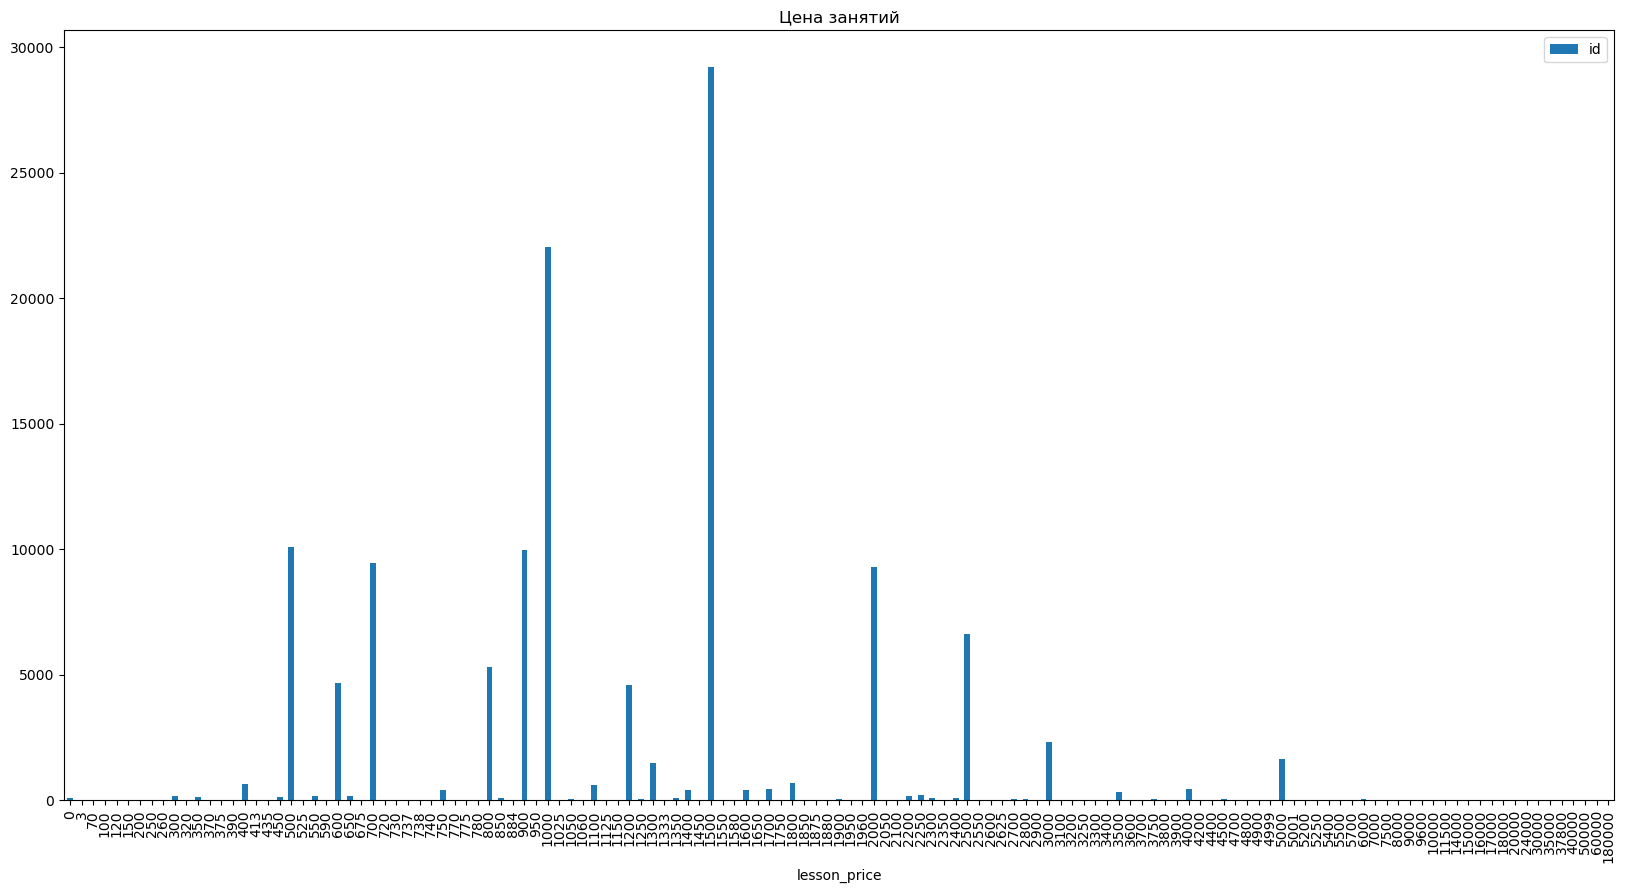

In [ ]:
# выведем распределение по цене занятия
price = orders.pivot_table(index='lesson_price', values='id', aggfunc='count')
price.plot.bar(figsize = (20,10))
plt.title('Цена занятий')
plt.show()

In [ ]:
# выведем самые популярные значения
orders['lesson_price'].value_counts().nlargest(10)

lesson_price
1500    29209
1000    22049
500     10089
900      9967
700      9455
2000     9309
2500     6619
800      5320
600      4692
1200     4609
Name: count, dtype: int64

Оставим более популярные значения:

In [ ]:
orders = orders.query('lesson_price >= 300 & lesson_price <= 8000').reset_index(drop=True)

Сгруппируем нужные признаки:

In [ ]:
orders.groupby(['id', 'client_id', 'lesson_place_new' ]).agg({'lesson_price': ['mean']})

lesson_price
                                          mean
id     client_id lesson_place_new             
87     443858    7                      1500.0
       525855    6                      1000.0
       878803    4                      1200.0
       888028    4                      1500.0
       979247    4                      1000.0
...                                        ...
311130 1263326   4                      1000.0
311156 1256954   4                       700.0
311168 1003438   7                       900.0
       1266116   4                      1000.0
       1266420   4                      1600.0

[123346 rows x 1 columns]

У многих преподавателей цена в заявке разная, при проведении занятий одного и того же формата (т.е дома, онлайн, у ученика)

In [ ]:
orders.groupby(['id', 'lesson_place_new', 'lesson_price' ]).size().reset_index(name='count')

,id,lesson_place_new,lesson_price,count
0,87,4,1000,2
1,87,4,1200,1
2,87,4,1500,2
3,87,6,1000,1
4,87,7,1500,1
...,...,...,...,...
83503,311130,4,1000,2
83504,311156,4,700,1
83505,311168,4,1000,1
83506,311168,4,1600,1


Выдигаем гипотезу, что при разной стоимости в равных условиях проведения занятия - это как минимум подозрительно. Напишем функцию.

In [ ]:
# создадим столбец с нулями
orders['suspicious'] = 0

In [ ]:

def compare_prices(row):
    # получаем индекс текущей строки
    index = row.name
    # получаем все строки, где репетитор совпадает с текущим
    same_teacher = df.loc[df['id'] == row['id']]
    # проверяем, совпадает ли место проведения и цена с текущими
    for i in range(len(same_teacher)):
        if (same_teacher.iloc[i]['lesson_place_new'] == row['lesson_place_new']) and (same_teacher.iloc[i]['lesson_price'] != row['lesson_price']):
            # если найдено несовпадение, обновляем значение в новом столбце
            df.loc[index, 'suspicious'] = 1
            # заменяем все значения у данного учителя в столбце сравнения на 1
            df.loc[df['id'] == row['id'], 'suspicious'] = 1
            break
    return df.loc[index, 'suspicious']


In [ ]:
# заполним новый признак по месту проведения занятия
orders['suspicious'] = orders.apply(compare_prices, axis=1)

In [ ]:
# проверяем
orders['suspicious'].value_counts()

suspicious
1.0    116666
Name: count, dtype: int64

In [ ]:
# заполняем пропуска и правим тип данных
orders['suspicious'].fillna(value= 0 , inplace= True )
orders['suspicious'] = orders['suspicious'].astype(int)

In [ ]:
orders['suspicious'].value_counts()

suspicious
1    116666
0      6711
Name: count, dtype: int64

In [ ]:
display(orders.head())

,id,client_id,lesson_price,lesson_place_new,suspicious
0,175576,1024446,1000,4,1
1,259733,1024455,900,4,1
2,99824,1024457,1000,2,1
3,159485,1024458,600,4,1
4,82420,1024471,900,4,1


In [ ]:
# сгруппируем по каждому id
orders = orders.groupby(['id']).agg(suspicious=('suspicious', 'mean'))

In [ ]:
display(orders.head())

,suspicious
id,
87,0.857143
106,0.888889
109,1.000000
112,1.000000
120,1.000000


Заполним в качестве эксперимента

In [ ]:
def susp(row):

    if row['suspicious'] >= 0.5:
        return 1
    return 0

orders['suspicious'] = orders.progress_apply(susp, axis=1)

  0%|          | 0/24883 [00:00<?, ?it/s]

In [ ]:
orders

,suspicious
id,
87,1
106,1
109,1
112,1
120,1
...,...
311086,1
311110,1
311130,1


### Финальная таблица "orders"

In [ ]:
display(orders)

,suspicious
id,
87,1
106,1
109,1
112,1
120,1
...,...
311086,1
311110,1
311130,1


## Обьединение таблиц, генерация фитчей

In [ ]:
df = teachers.merge(teachers_info, on = 'id', how = 'left')

In [ ]:
display(df)

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_term,age,...,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,phone,area_id,sex,orders_allowed,review_num
0,198013,470,1284.22,469,0.67,78,602300,0,3.0,26.0,...,60.0,800.0,1.0,2022-10-21,3.0,0.0,2.0,1.0,1.0,10.0
1,153845,1111,884.09,1082,0.36,77,956580,0,5.0,56.0,...,60.0,600.0,1.0,2022-10-22,3.0,0.0,13.0,2.0,1.0,26.0
2,42869,505,2500.00,184,0.14,61,460000,0,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,127280,442,1879.34,363,0.15,60,682200,0,6.0,37.0,...,60.0,1500.0,1.0,2022-03-17,3.0,0.0,1.0,2.0,1.0,10.0
4,283905,694,1252.43,534,0.26,59,668800,0,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,294498,1,1500.00,1,0.17,1,1500,0,0.0,27.0,...,60.0,1500.0,0.0,NaT,3.0,0.0,38.0,2.0,1.0,1.0
1652,3619,1,1300.00,1,0.11,1,1300,0,15.0,36.0,...,60.0,1300.0,1.0,2022-10-23,0.0,0.0,1.0,2.0,1.0,3.0
1653,238509,4,900.00,1,0.07,1,900,1,2.0,28.0,...,60.0,700.0,1.0,2022-10-19,3.0,0.0,6.0,2.0,0.0,4.0
1654,180353,1,1700.00,1,0.10,1,1700,0,4.0,47.0,...,60.0,1400.0,1.0,2022-10-24,3.0,0.0,2.0,2.0,1.0,11.0


In [ ]:
display(df.isna().sum())

id                            0
lessons_delivered             0
mean_lesson_price             0
lessons_given                 0
lessons_started_fraction      0
lessons_per_pupil             0
money_recieved                0
blocked                       0
reg_term                    208
age                         208
teach_term                  208
email                       208
lesson_duration             208
lesson_cost                 208
is_display                  208
last_visited                517
is_pupils_needed            208
phone                       208
area_id                     208
sex                         208
orders_allowed              208
review_num                  208
dtype: int64

Удалим признак "last_visited" треть пропусков:

In [ ]:
df.drop('last_visited', axis= 1, inplace= True )

Из-за утечки данных удалим столбец "orders_allowed":

In [ ]:
df.drop('orders_allowed', axis= 1, inplace= True )

In [ ]:
#total_isnull = df.loc[df.isnull().any(axis=1)]
#total_isnull

Для эскперимента удалим репетиторов с пропусками в данных:

In [ ]:
df = df.dropna()

In [ ]:
df = df.reset_index(drop=True)

Для универсальности модели создадим новый признак соотношение оплаченных уроков и поставленных:

In [ ]:
df['lessons_fraction'] = round (df['lessons_given'] /  df['lessons_delivered'] , 2)

In [ ]:
df.drop(['lessons_given', 'lessons_delivered'], axis= 1 , inplace= True )

Удалим признак с абсолюной величиной - сумма заработанных денег. Количество не влияет на порядочность:

In [ ]:
df.drop('money_recieved', axis= 1, inplace= True )

In [ ]:
df

,id,mean_lesson_price,lessons_started_fraction,lessons_per_pupil,blocked,reg_term,age,teach_term,email,lesson_duration,lesson_cost,is_display,is_pupils_needed,phone,area_id,sex,review_num,lessons_fraction
0,198013,1284.22,0.67,78,0,3.0,26.0,6.0,0.0,60.0,800.0,1.0,3.0,0.0,2.0,1.0,10.0,1.00
1,153845,884.09,0.36,77,0,5.0,56.0,38.0,0.0,60.0,600.0,1.0,3.0,0.0,13.0,2.0,26.0,0.97
2,127280,1879.34,0.15,60,0,6.0,37.0,18.0,0.0,60.0,1500.0,1.0,3.0,0.0,1.0,2.0,10.0,0.82
3,278907,1195.76,0.29,59,0,1.0,22.0,1.0,0.0,45.0,750.0,1.0,3.0,0.0,1.0,1.0,0.0,0.97
4,88923,1776.10,0.68,57,0,8.0,28.0,10.0,0.0,60.0,2200.0,1.0,3.0,0.0,1.0,1.0,48.0,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,294498,1500.00,0.17,1,0,0.0,27.0,6.0,0.0,60.0,1500.0,0.0,3.0,0.0,38.0,2.0,1.0,1.00
1444,3619,1300.00,0.11,1,0,15.0,36.0,18.0,0.0,60.0,1300.0,1.0,0.0,0.0,1.0,2.0,3.0,1.00
1445,238509,900.00,0.07,1,1,2.0,28.0,6.0,0.0,60.0,700.0,1.0,3.0,0.0,6.0,2.0,4.0,0.25
1446,180353,1700.00,0.10,1,0,4.0,47.0,8.0,0.0,60.0,1400.0,1.0,3.0,0.0,2.0,2.0,11.0,1.00


In [ ]:
df = df.merge(orders, on = 'id', how = 'left')

In [ ]:
df

,id,mean_lesson_price,lessons_started_fraction,lessons_per_pupil,blocked,reg_term,age,teach_term,email,lesson_duration,lesson_cost,is_display,is_pupils_needed,phone,area_id,sex,review_num,lessons_fraction,suspicious
0,198013,1284.22,0.67,78,0,3.0,26.0,6.0,0.0,60.0,800.0,1.0,3.0,0.0,2.0,1.0,10.0,1.00,1.0
1,153845,884.09,0.36,77,0,5.0,56.0,38.0,0.0,60.0,600.0,1.0,3.0,0.0,13.0,2.0,26.0,0.97,1.0
2,127280,1879.34,0.15,60,0,6.0,37.0,18.0,0.0,60.0,1500.0,1.0,3.0,0.0,1.0,2.0,10.0,0.82,1.0
3,278907,1195.76,0.29,59,0,1.0,22.0,1.0,0.0,45.0,750.0,1.0,3.0,0.0,1.0,1.0,0.0,0.97,1.0
4,88923,1776.10,0.68,57,0,8.0,28.0,10.0,0.0,60.0,2200.0,1.0,3.0,0.0,1.0,1.0,48.0,0.66,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,294498,1500.00,0.17,1,0,0.0,27.0,6.0,0.0,60.0,1500.0,0.0,3.0,0.0,38.0,2.0,1.0,1.00,1.0
1444,3619,1300.00,0.11,1,0,15.0,36.0,18.0,0.0,60.0,1300.0,1.0,0.0,0.0,1.0,2.0,3.0,1.00,1.0
1445,238509,900.00,0.07,1,1,2.0,28.0,6.0,0.0,60.0,700.0,1.0,3.0,0.0,6.0,2.0,4.0,0.25,1.0
1446,180353,1700.00,0.10,1,0,4.0,47.0,8.0,0.0,60.0,1400.0,1.0,3.0,0.0,2.0,2.0,11.0,1.00,1.0


In [ ]:
display(df.isna().sum())

id                            0
mean_lesson_price             0
lessons_started_fraction      0
lessons_per_pupil             0
blocked                       0
reg_term                      0
age                           0
teach_term                    0
email                         0
lesson_duration               0
lesson_cost                   0
is_display                    0
is_pupils_needed              0
phone                         0
area_id                       0
sex                           0
review_num                    0
lessons_fraction              0
suspicious                  104
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

,id,mean_lesson_price,lessons_started_fraction,lessons_per_pupil,blocked,reg_term,age,teach_term,email,lesson_duration,lesson_cost,is_display,is_pupils_needed,phone,area_id,sex,review_num,lessons_fraction,suspicious
0,198013,1284.22,0.67,78,0,3.0,26.0,6.0,0.0,60.0,800.0,1.0,3.0,0.0,2.0,1.0,10.0,1.00,1.0
1,153845,884.09,0.36,77,0,5.0,56.0,38.0,0.0,60.0,600.0,1.0,3.0,0.0,13.0,2.0,26.0,0.97,1.0
2,127280,1879.34,0.15,60,0,6.0,37.0,18.0,0.0,60.0,1500.0,1.0,3.0,0.0,1.0,2.0,10.0,0.82,1.0
3,278907,1195.76,0.29,59,0,1.0,22.0,1.0,0.0,45.0,750.0,1.0,3.0,0.0,1.0,1.0,0.0,0.97,1.0
4,88923,1776.10,0.68,57,0,8.0,28.0,10.0,0.0,60.0,2200.0,1.0,3.0,0.0,1.0,1.0,48.0,0.66,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,294498,1500.00,0.17,1,0,0.0,27.0,6.0,0.0,60.0,1500.0,0.0,3.0,0.0,38.0,2.0,1.0,1.00,1.0
1340,3619,1300.00,0.11,1,0,15.0,36.0,18.0,0.0,60.0,1300.0,1.0,0.0,0.0,1.0,2.0,3.0,1.00,1.0
1341,238509,900.00,0.07,1,1,2.0,28.0,6.0,0.0,60.0,700.0,1.0,3.0,0.0,6.0,2.0,4.0,0.25,1.0
1342,180353,1700.00,0.10,1,0,4.0,47.0,8.0,0.0,60.0,1400.0,1.0,3.0,0.0,2.0,2.0,11.0,1.00,1.0


Сгенерируем ещё один признак по гипотезе, связанной со стоимостью занятия в зависимости от региона

In [ ]:
def cost(row):

    if row['lesson_cost'] < 700 and row['area_id'] ==1:
        return 1
    return 0

    if row['lesson_cost'] < 500 and row['area_id'] !=1:
        return 1
    return 0

df['susp_cost'] = df.progress_apply(cost, axis=1)

  0%|          | 0/1344 [00:00<?, ?it/s]

In [ ]:
df

,id,mean_lesson_price,lessons_started_fraction,lessons_per_pupil,blocked,reg_term,age,teach_term,email,lesson_duration,lesson_cost,is_display,is_pupils_needed,phone,area_id,sex,review_num,lessons_fraction,suspicious,susp_cost
0,198013,1284.22,0.67,78,0,3.0,26.0,6.0,0.0,60.0,800.0,1.0,3.0,0.0,2.0,1.0,10.0,1.00,1.0,0
1,153845,884.09,0.36,77,0,5.0,56.0,38.0,0.0,60.0,600.0,1.0,3.0,0.0,13.0,2.0,26.0,0.97,1.0,0
2,127280,1879.34,0.15,60,0,6.0,37.0,18.0,0.0,60.0,1500.0,1.0,3.0,0.0,1.0,2.0,10.0,0.82,1.0,0
3,278907,1195.76,0.29,59,0,1.0,22.0,1.0,0.0,45.0,750.0,1.0,3.0,0.0,1.0,1.0,0.0,0.97,1.0,0
4,88923,1776.10,0.68,57,0,8.0,28.0,10.0,0.0,60.0,2200.0,1.0,3.0,0.0,1.0,1.0,48.0,0.66,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,294498,1500.00,0.17,1,0,0.0,27.0,6.0,0.0,60.0,1500.0,0.0,3.0,0.0,38.0,2.0,1.0,1.00,1.0,0
1340,3619,1300.00,0.11,1,0,15.0,36.0,18.0,0.0,60.0,1300.0,1.0,0.0,0.0,1.0,2.0,3.0,1.00,1.0,0
1341,238509,900.00,0.07,1,1,2.0,28.0,6.0,0.0,60.0,700.0,1.0,3.0,0.0,6.0,2.0,4.0,0.25,1.0,0
1342,180353,1700.00,0.10,1,0,4.0,47.0,8.0,0.0,60.0,1400.0,1.0,3.0,0.0,2.0,2.0,11.0,1.00,1.0,0


In [ ]:
df['susp_cost'].value_counts()

susp_cost
0    1240
1     104
Name: count, dtype: int64

По корреляции будет видно полезность данного признака

In [ ]:
# проверим ещё раз на дубликаты после предобработки
df.duplicated().sum()

0

## Проверка корреляции

blocked
0    0.636905
1    0.363095
Name: proportion, dtype: float64


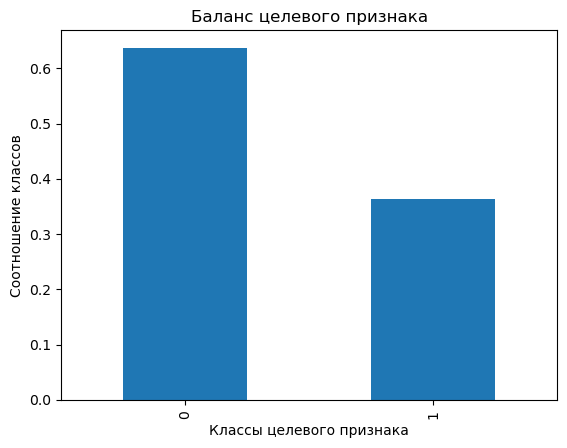

In [ ]:
# проверим, как часто в целевом признаке встречается класс «1» или «0»
class_frequency = df['blocked'].value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar')
plt.title('Баланс целевого признака')
plt.ylabel('Соотношение классов')
plt.xlabel('Классы целевого признака')
plt.show()

Баланс классов смещен.

In [ ]:
# удалим столбец id для исследования корреляции
df.drop('id', axis= 1 , inplace= True )

In [ ]:
# получаем матрицу значимости корреляции
phik_overview = df.phik_matrix(interval_cols=['blocked', 'mean_lesson_price', 'lessons_fraction',
                                              'lessons_started_fraction', 'lessons_per_pupil',
                                              'reg_term', 'age', 'teach_term', 'email', 'lesson_duration',
                                              'lesson_cost', 'is_display', 'is_pupils_needed', 'phone',
                                              'area_id', 'sex', 'review_num', 'suspicious', 'susp_cost'])['blocked']
phik_overview.round(2)

mean_lesson_price           0.11
lessons_started_fraction    0.31
lessons_per_pupil           0.30
blocked                     1.00
reg_term                    0.00
age                         0.14
teach_term                  0.10
email                       0.01
lesson_duration             0.00
lesson_cost                 0.02
is_display                  0.00
is_pupils_needed            0.00
phone                       0.06
area_id                     0.06
sex                         0.00
review_num                  0.09
lessons_fraction            0.00
suspicious                  0.00
susp_cost                   0.08
Name: blocked, dtype: float64

Text(0.5, 135.5815972222222, 'Признаки')

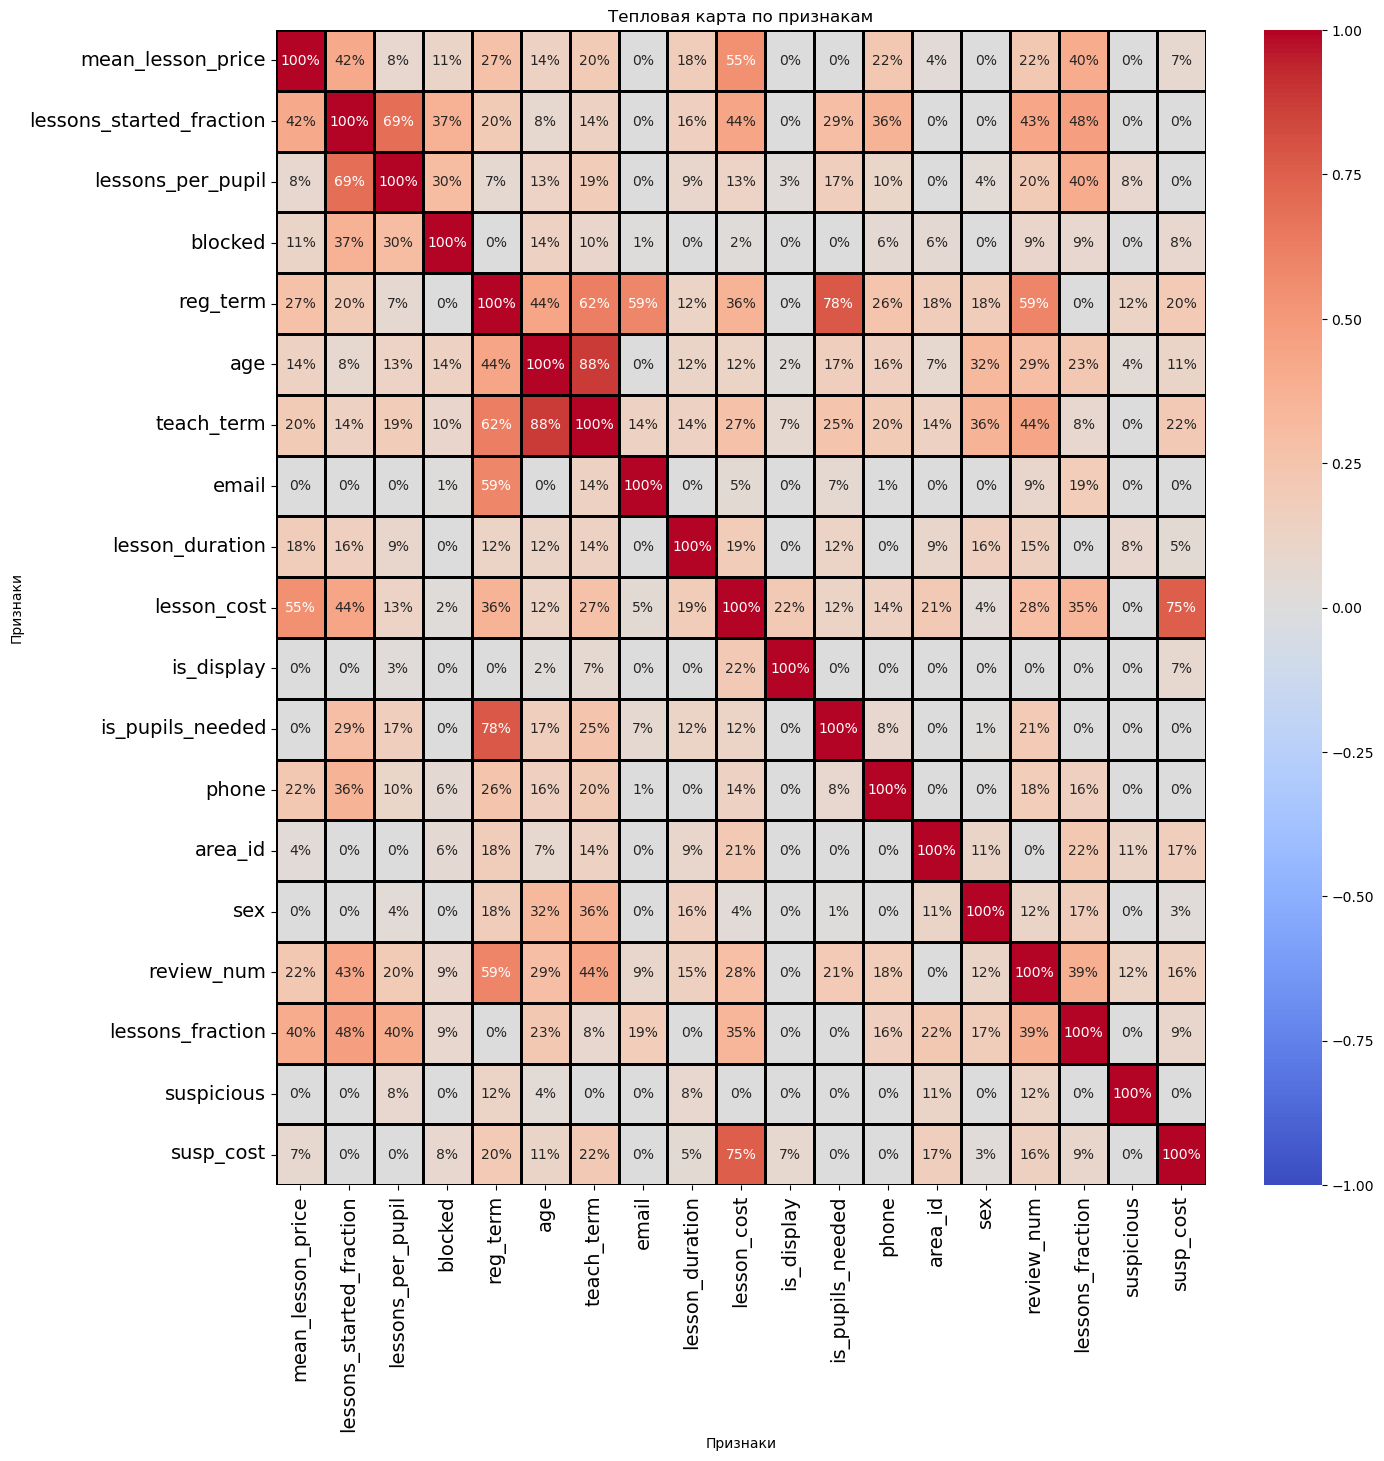

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.phik_matrix(interval_cols=['blocked', 'mean_lesson_price', 'lessons_fraction'
                                              'lessons_started_fraction', 'lessons_per_pupil',
                                              'reg_term', 'age', 'teach_term', 'email', 'lesson_duration',
                                              'lesson_cost', 'is_display', 'is_pupils_needed', 'phone',
                                              'area_id', 'sex', 'review_num', 'suspicious', 'susp_cost']),
                                           annot = True, fmt='.0%', vmin=-1, vmax=1,
                                           center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')
plt.title('Тепловая карта по признакам')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=360)
plt.ylabel('Признаки')
plt.xlabel('Признаки')

Удалим признаки с низкой корреляцией 0:

In [ ]:
 df.drop(['reg_term', 'lesson_duration', 'is_display', 'suspicious', 'email',
            'is_pupils_needed', 'sex' ], axis= 1 , inplace= True )

In [ ]:
df

,mean_lesson_price,lessons_started_fraction,lessons_per_pupil,blocked,age,teach_term,lesson_cost,phone,area_id,review_num,lessons_fraction,susp_cost
0,1284.22,0.67,78,0,26.0,6.0,800.0,0.0,2.0,10.0,1.00,0
1,884.09,0.36,77,0,56.0,38.0,600.0,0.0,13.0,26.0,0.97,0
2,1879.34,0.15,60,0,37.0,18.0,1500.0,0.0,1.0,10.0,0.82,0
3,1195.76,0.29,59,0,22.0,1.0,750.0,0.0,1.0,0.0,0.97,0
4,1776.10,0.68,57,0,28.0,10.0,2200.0,0.0,1.0,48.0,0.66,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1339,1500.00,0.17,1,0,27.0,6.0,1500.0,0.0,38.0,1.0,1.00,0
1340,1300.00,0.11,1,0,36.0,18.0,1300.0,0.0,1.0,3.0,1.00,0
1341,900.00,0.07,1,1,28.0,6.0,700.0,0.0,6.0,4.0,0.25,0
1342,1700.00,0.10,1,0,47.0,8.0,1400.0,0.0,2.0,11.0,1.00,0


In [ ]:
phik_overview = df.phik_matrix(interval_cols=['mean_lesson_price', 'lessons_started_fraction', 'lessons_per_pupil',
                                              'blocked', 'age', 'teach_term', 'lesson_cost', 'review_num',
                                              'lessons_given', 'lessons_delivered'])['blocked']
phik_overview.round(2)

mean_lesson_price           0.11
lessons_started_fraction    0.31
lessons_per_pupil           0.30
blocked                     1.00
age                         0.14
teach_term                  0.10
lesson_cost                 0.02
phone                       0.06
area_id                     0.10
review_num                  0.09
lessons_fraction            0.09
susp_cost                   0.08
Name: blocked, dtype: float64

## Обучение моделей

#### Извлечение признаков

In [ ]:
# извлекаем признаки
X = df.drop(['blocked'], axis=1)

In [ ]:
# извлекаем целевой признак
y = df['blocked']

In [ ]:
# выделяем 75% данных для обучающей выборки, остальные данные для тестовой.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y,
                                                    test_size=0.3)

In [ ]:
print('Форма обучающей выборки:', X_train.shape)
print('Форма тестовой выборки:', X_test.shape)

Форма обучающей выборки: (940, 11)
Форма тестовой выборки: (404, 11)


In [ ]:
# сбросим индексы
for i in [X_train, X_test, y_train, y_test]:
    i.reset_index(drop=True, inplace=True)

In [ ]:
# трансформер для линейных моделей соберем из ОНЕ для категориальных,
# к числовым - StandardScaler
linear_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),
     make_column_selector(
         dtype_include=['category', 'object'])),
    (StandardScaler(), make_column_selector(dtype_include='number')),
    remainder='drop')

In [ ]:
# трансформер для различных колонок из ОЕ для категориальных признаков,
# числовые оставим как есть.
ensemble_transformer = make_column_transformer(
    (OrdinalEncoder(
         handle_unknown='use_encoded_value', unknown_value=-1),
     make_column_selector(
         dtype_include=['category', 'object'])),
    (MaxAbsScaler(), make_column_selector(dtype_include='number')),
     remainder='drop', verbose_feature_names_out=False)

#### Модель RandomForestClassifier

In [ ]:
# pipeline RandomForestClassifier
pipe_rf = make_pipeline(ensemble_transformer,
    RandomForestClassifier(class_weight='balanced',
                           n_jobs=-1,
                           verbose=0,
                           random_state=RANDOM_STATE))

In [ ]:
# подбираем гиперпарамаметры для модели RandomForestClassifier
param_grid = {
    'randomforestclassifier__max_depth': [None] + [i for i in range(2, 11)],
    'randomforestclassifier__n_estimators':np.arange(50, 1001, 50)
}

grid_rf = GridSearchCV(pipe_rf,
                     param_grid,
                     scoring='f1',
                     cv=2,
                     n_jobs=-1,
                     verbose=1)

In [ ]:
%%time

# инициализируем модель RandomForestClassifier
grid_rf.fit(X_train, y_train)

Fitting 2 folds for each of 200 candidates, totalling 400 fits
CPU times: user 756 ms, sys: 250 ms, total: 1.01 s
Wall time: 44.7 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x15ba5a950>),
                                                                        ('maxabsscaler',
                                                                         MaxAbsScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector...
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=12345))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [None, 2, 3, 4, 5,
                                                               6, 7, 8, 9, 10],
                         'randomforestclassifier__n_estimators': array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])},
             scoring='f1', verbose=1)

In [ ]:
# выведем лучшие гиперпараметры для RandomForestClassifier
grid_rf.best_params_

{'randomforestclassifier__max_depth': 3,
 'randomforestclassifier__n_estimators': 450}

In [ ]:
# выведем оценку F1 для RandomForestClassifier на кросс-валидации
score_rf = round(grid_rf.best_score_, 3)
score_rf

0.611

#### Модель  LightGBM

In [ ]:
# pipeline LightGBM
pipe_gbm = make_pipeline(ensemble_transformer,
    lgb.LGBMClassifier(objective='binary',
                       metric='f1',
                       n_jobs=-1,
                       verbosity=-1,
                       random_state=RANDOM_STATE))


In [ ]:
# подбираем гиперпарамаметры для модели LightGBM
param_grid = {
    'lgbmclassifier__max_depth':[ 3, 5, 7, 9, 11],
    'lgbmclassifier__num_leaves':[ 3, 5, 10, 15],
    'lgbmclassifier__learning_rate':[0.001, 0.01, 0.1, 0.5],
    'lgbmclassifier__n_estimators' : [25, 50, 100],

}

grid_gbm = GridSearchCV(pipe_gbm,
                      param_grid,
                      scoring='f1',
                      cv=2,
                      n_jobs=-1,
                      verbose=1)

In [ ]:
%%time

# инициализируем модель LightGBM
grid_gbm.fit(X_train, y_train)

Fitting 2 folds for each of 240 candidates, totalling 480 fits
CPU times: user 468 ms, sys: 144 ms, total: 613 ms
Wall time: 17.1 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x15ba5a950>),
                                                                        ('maxabsscaler',
                                                                         MaxAbsScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector...
                                                          verbose_feature_names_out=False)),
                                       ('lgbmclassifier',
                                        LGBMClassifier(metric='f1', n_jobs=-1,
                                                       objective='binary',
                                                       random_state=12345,
                                                       verbosity=-1))]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__learning_rate': [0.001, 0.01, 0.1,
                                                           0.5],
                         'lgbmclassifier__max_depth': [3, 5, 7, 9, 11],
                         'lgbmclassifier__n_estimators': [25, 50, 100],
                         'lgbmclassifier__num_leaves': [3, 5, 10, 15]},
             scoring='f1', verbose=1)

In [ ]:
# выведем лучшие гиперпараметры для LightGBM
grid_gbm.best_params_

{'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': 3,
 'lgbmclassifier__n_estimators': 50,
 'lgbmclassifier__num_leaves': 3}

In [ ]:
# выведем оценку F1 для LightGBM на кросс-валидации
score_gbm = round(grid_gbm.best_score_, 3)
score_gbm

0.561

#### Модель  CatBoostClassifier

In [ ]:
# pipeline CatBoostClassifier
pipe_cat = make_pipeline(ensemble_transformer,
     CatBoostClassifier(logging_level='Silent',
                        loss_function='Logloss',
                       random_state=RANDOM_STATE))

In [ ]:
# подбираем гиперпарамаметры для модели CatBoostClassifier
param_grid = {
    'catboostclassifier__max_depth': [ 2, 3, 5, 7],
    'catboostclassifier__learning_rate': [ 0.1, 0.25, 0.5],
    'catboostclassifier__n_estimators' : [ 20, 50, 100, 200, 300],
    'catboostclassifier__l2_leaf_reg': [  11, 13, 15]
}

grid_cat = GridSearchCV(pipe_cat,
                      param_grid,
                      scoring='f1',
                      cv=3,
                      n_jobs=-1,
                      verbose=1)

In [ ]:
%%time

# инициализируем модель CatBoostClassifier
grid_cat.fit(X_train, y_train)


Fitting 3 folds for each of 180 candidates, totalling 540 fits
CPU times: user 528 ms, sys: 192 ms, total: 720 ms
Wall time: 8.59 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x15ba5a950>),
                                                                        ('maxabsscaler',
                                                                         MaxAbsScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector...
                                                          verbose_feature_names_out=False)),
                                       ('catboostclassifier',
                                        <catboost.core.CatBoostClassifier object at 0x15bddfcd0>)]),
             n_jobs=-1,
             param_grid={'catboostclassifier__l2_leaf_reg': [11, 13, 15],
                         'catboostclassifier__learning_rate': [0.1, 0.25, 0.5],
                         'catboostclassifier__max_depth': [2, 3, 5, 7],
                         'catboostclassifier__n_estimators': [20, 50, 100, 200,
                                                              300]},
             scoring='f1', verbose=1)

In [ ]:
# выведем лучшие гиперпараметры для CatBoostClassifier
grid_cat.best_params_

{'catboostclassifier__l2_leaf_reg': 13,
 'catboostclassifier__learning_rate': 0.25,
 'catboostclassifier__max_depth': 2,
 'catboostclassifier__n_estimators': 100}

In [ ]:
# выведем оценку F1 для CatBoostClassifier на кросс-валидации
score_cat = round(grid_cat.best_score_, 3)
score_cat

0.587

### Вывод

Обучили 3 модели: RandomForestClassifier, LightGBM, CatBoostClassifier.
Получили следующие показания определяющей метрики F-1.

In [ ]:
# сводная таблица по показателям F1 :
index = ['RandomForestClassifier',
         'LightGBM',
         'CatBoostClassifier']

data = {'F1-мера':[score_rf,
                   score_gbm,
                   score_cat]}

data = pd.DataFrame(data=data, index=index)

data.sort_values(by ='F1-мера', ascending=False)

,F1-мера
RandomForestClassifier,0.611
CatBoostClassifier,0.587
LightGBM,0.561


## Тестирование лучших моделей

In [ ]:
predicted_rf = grid_rf.predict(X_test)

In [ ]:
print("F1-мера для тестовой выборки: ", round(f1_score(y_test, predicted_rf), 3))

F1-мера для тестовой выборки:  0.625


Проведем графический анализ «Матрица ошибок». Выведите полноту и точность на график.

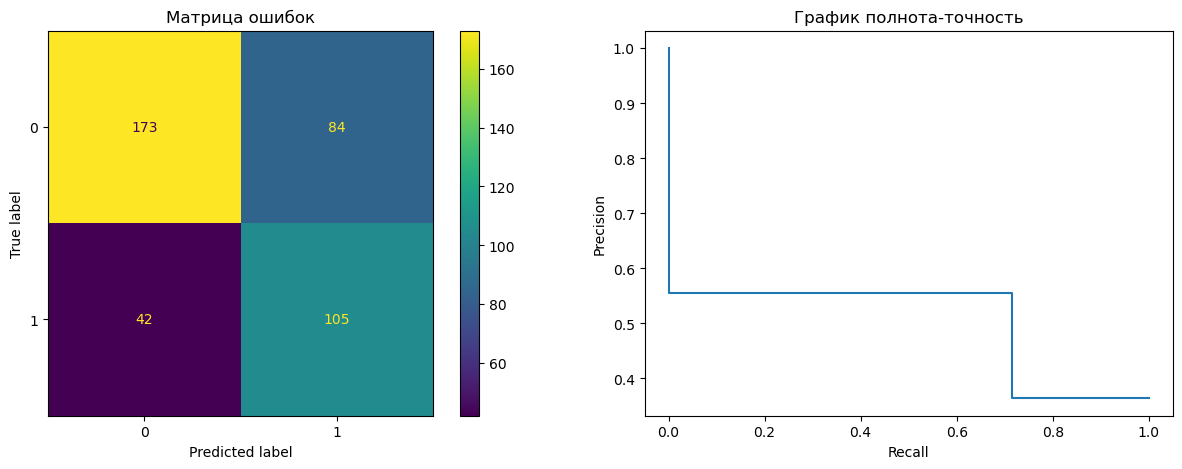

In [ ]:
cm = confusion_matrix(y_test, predicted_rf, labels=grid_rf.classes_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_rf.classes_)
cmd.plot(ax=ax1)
ax1.set_title('Матрица ошибок')
prec, recall, _ = precision_recall_curve(y_test, predicted_rf)
PrecisionRecallDisplay(prec, recall).plot(ax=ax2)
ax2.set_title('График полнота-точность')
plt.show()

Модель RandomForestClassifier¶  предсказывает True Negative (173) в нашем случае репетиторов, которые не обманывают компанию. False Positive (42) - это репетиторы, которых модель ложно определила, как обманывающих компанию. True Positive (105) - это репетиторы, действительно обманывающие компанию и False Negative (84) - репетиторы, которых модель ложно определила, как благонадежных. Используя эти данные мы можем определить обьём проверок репетиров (True Positive, False Negative).

In [ ]:
predicted_cat = grid_cat.predict(X_test)

In [ ]:
print("F1-мера для тестовой выборки: ", round(f1_score(y_test, predicted_cat), 3))

F1-мера для тестовой выборки:  0.558


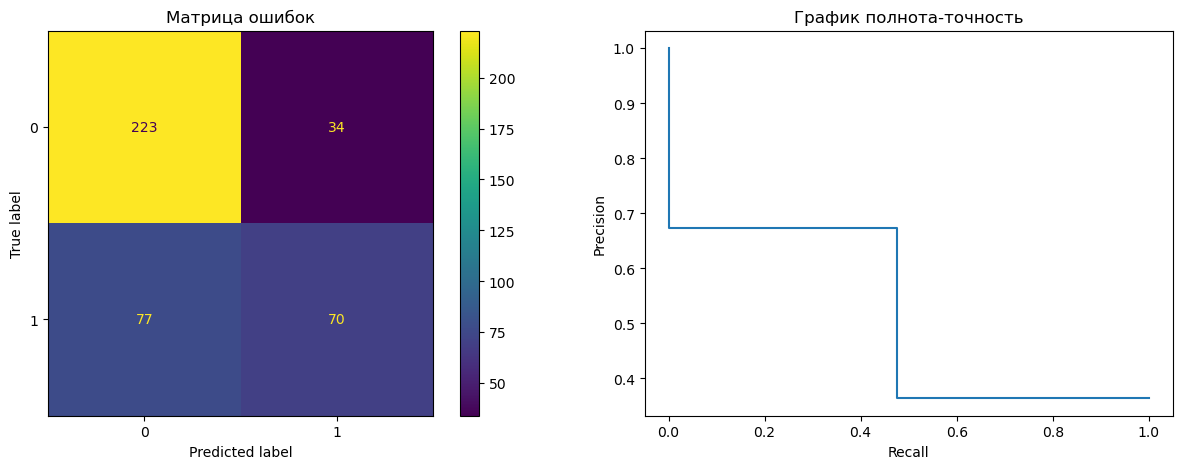

In [ ]:
cm = confusion_matrix(y_test, predicted_cat, labels=grid_cat.classes_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_cat.classes_)
cmd.plot(ax=ax1)
ax1.set_title('Матрица ошибок')
prec, recall, _ = precision_recall_curve(y_test, predicted_cat)
PrecisionRecallDisplay(prec, recall).plot(ax=ax2)
ax2.set_title('График полнота-точность')
plt.show()

Модель CatBoostClassifier хорошо предсказывает True Negative (223) в нашем случае репетиторов, которые не обманывают компанию. False Positive (77) - это репетиторы, которых модель ложно определила, как обманывающих компанию. True Positive (70) - это репетиторы, действительно обманывающие компанию и False Negative (34) - репетиторы, которых модель ложно определила, как благонадежных. Используя эти данные мы можем определить обьём проверок репетиров (True Positive, False Negative).

## Заключение

По метрике F1 лучше показала себя модель RandomForestClassifier, но анализируя матрицу ошибок сделал вывод, что модель CatBoostClassifier более полезна для предсказания недобросовестных репетиторов. Если брать нашу тестовую выборку 404 обьекта модель RandomForestClassifier для проверки выдаёт 189 репетиторов, CatBoostClassifier 104 репетиторов. Для улучшения качества метрики рекомендуется увеличить тренировочную выборку.